<a href="https://colab.research.google.com/github/Amira-Ali/Predictive-Maintenance-With-ML/blob/main/predictive_maintenance_with_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives:

The objectives of this project are as follows:

* To experiment with different classification methods to see which yields the highest accuracy
* To determine which features are the most indicative of a broken machine



In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['axes.grid'] = True

In [60]:
! pip install kaggle

In [61]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [62]:
! cp kaggle.json ~/.kaggle/

In [63]:
! chmod 600 ~/.kaggle/kaggle.json

In [64]:
! kaggle datasets download nphantawee/pump-sensor-data

pump-sensor-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
! mkdir sensordata

mkdir: cannot create directory ‘sensordata’: File exists


In [66]:
! unzip /content/pump-sensor-data.zip -d sensordata/

Archive:  /content/pump-sensor-data.zip
replace sensordata/sensor.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### Data Anlaysis :
##### Main aim is to understand more about the data.
- Categorical Variables: 
    - How many.
    - Cardinality of Categorical Variables (bar): to decide later which to use label encoding or one-hot encoding
    
- Numerical Variables:
   - How many.
   - Distribution of the Numerical Variables (histogram,line): use this information later at the preoprocessing stage.
      - Data skewed left\right => data has outliers or has many missing values.
      - The goal is to convert non noraml distribution to more like normal one.
      - The converting is done by: cleaning data, removing outliers, filling missing values with median if outliers exist, etc.

- All Features:
    - Missing Values: calculate NAN% in each var to decide whether to drop the feature or filling it with the proper strategy
    - Duplicates
    - Outliers: detect Outliers with(boxplot, IQR) 
    - Relationship between independent and dependent feature(machine_status): gonna postpone this step till later after label encoding the target and setting timestamp as our data index

In [67]:
dataset = pd.read_csv("sensordata/sensor.csv")
dataset.shape

(220320, 55)

In [68]:
dataset.head(5)

Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  \
0  46.310760   634.3750   76.45975   13.41146   16.13136   15.56713   
1  46.310760   634.3750   76.45975   13.41146   16.13136   15.56713   
2  46.397570   638.8889   73.54598   13.32465   16.03733   15.61777   
3  46.397568   628.1250   76.98898   13.31742   16.24711   15.69734   
4  46.397568   636.4583   76.58897   13.35359   16.21094   15.69734   

   sensor_09  sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  \
0   15.05353   37.22740   47.52422   31.11716   1.681353   419.5747   
1   15.05353   37.22740   47.52422   31.11716   1.681353   419.5747   
2   15.01013   37.86777   48.17723   32.08894   1.708474   420.8480   
3   15.08247   38.57977   48.65607   31.67221   1.579427   420.7494   
4   15.08247   39.48939   49.06298   31.95202   1.683831   419.8926   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0        NaN   461.8781   466.3284   2.565284   665.3993   398.9862   
1        NaN   461.8781   466.3284   2.565284   665.3993   398.9862   
2        NaN   462.7798   459.6364   2.500062   666.2234   399.9418   
3        NaN   462.8980   460.8858   2.509521   666.0114   399.1046   
4        NaN   461.4906   468.2206   2.604785   663.2111   400.5426   

   sensor_21  sensor_22  sensor_23  sensor_24  sensor_25  sensor_26  \
0   880.0001   498.8926   975.9409   627.6740   741.7151   848.0708   
1   880.0001   498.8926   975.9409   627.6740   741.7151   848.0708   
2   880.4237   501.3617   982.7342   631.1326   740.8031   849.8997   
3   878.8917   499.0430   977.7520   625.4076   739.2722   847.7579   
4   882.5874   498.5383   979.5755   627.1830   737.6033   846.9182   

   sensor_27  sensor_28  sensor_29  sensor_30  sensor_31  sensor_32  \
0   429.0377   785.1935   684.9443   594.4445   682.8125   680.4416   
1   429.0377   785.1935   684.9443   594.4445   682.8125   680.4416   
2   454.2390   778.5734   715.6266   661.5740   721.8750   694.7721   
3   474.8731   779.5091   690.4011   686.1111   754.6875   683.3831   
4   408.8159   785.2307   704.6937   631.4814   766.1458   702.4431   

   sensor_33  sensor_34  sensor_35  sensor_36  sensor_37  sensor_38  \
0   433.7037   171.9375   341.9039   195.0655   90.32386   40.36458   
1   433.7037   171.9375   341.9039   195.0655   90.32386   40.36458   
2   441.2635   169.9820   343.1955   200.9694   93.90508   41.40625   
3   446.2493   166.4987   343.9586   193.1689  101.04060   41.92708   
4   433.9081   164.7498   339.9630   193.8770  101.70380   42.70833   

   sensor_39  sensor_40  sensor_41  sensor_42  sensor_43  sensor_44  \
0   31.51042   70.57291   30.98958  31.770832   41.92708  39.641200   
1   31.51042   70.57291   30.98958  31.770832   41.92708  39.641200   
2   31.25000   69.53125   30.46875  31.770830   41.66666  39.351852   
3   31.51042   72.13541   30.46875  31.510420   40.88541  39.062500   
4   31.51042   76.82291   30.98958  31.510420   41.40625  38.773150   

   sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  sensor_50  \
0   65.68287   50.92593  38.194440   157.9861   67.70834   243.0556   
1   65.68287   50.92593  38.194440   157.9861   67.70834   243.0556   
2   65.39352   51.21528  38.194443   155.9606   67.12963   241.3194   
3   64.81481   51.21528  38.194440   155.9606   66.84028   240.4514   
4   65.10416   51.79398  38.773150   158.2755   66.55093   242.1875   

   sensor_51 machine_status  
0   201.3889         NORMAL  
1   201.3889         NORMAL  
2   203.7037         NORMAL  
3   203.1250         NORMAL  
4   201.38

In [69]:
dataset.dtypes

Unnamed: 0          int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

In [70]:
#We'll have to convert timestamp to datetime and maybe index our data on it
#also we may have to categories the target 'machine_status'

### Categorical variables:
- How many?
- Cardinality of each feature: to decide later which to use label encoding or one-hot encoding (use bar chart)

In [71]:
dataset.describe(include='O')

timestamp machine_status
count                220320         220320
unique               220320              3
top     2018-06-17 18:51:00         NORMAL
freq                      1         205836

count only counts non-null values.
timestamp: count = unique ==> no nulls + no duplicate ==> use timestamp as our data index later at the data preprocessing stage

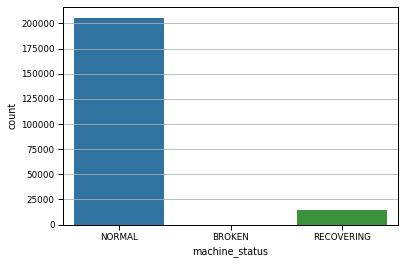

In [72]:
sns.countplot(x=dataset['machine_status'])

In [73]:
#List machine_status distinct values:
dataset['machine_status'].unique().tolist()

['NORMAL', 'BROKEN', 'RECOVERING']

In [74]:
#To check if the data is equally balanced between the target classes
dataset['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

machine_status: 3 distinct values, no nulls ==> use label-encoding since we only have 3 distict values

### Thoughts:

The water pumb got broken 7 times, which is a huge number for just one year.

We'll try to find out if there is any pattern that connects failure status to timestamp, does is it occur more at night time? early morning? afternoon? etc.

Of course if we have got more data or if sensors were defined appropriately instead of labelling them just with sensor number, we would have a more clear vision of what's going on. but for now we'll do our best with the data we have as it is.

In [75]:
#get timestamp where status == broken
timestamp = dataset[['timestamp','machine_status']].loc[dataset['machine_status'].str.lower()=='broken']
timestamp.set_index('timestamp', inplace= True)
timestamp

machine_status
timestamp                         
2018-04-12 21:55:00         BROKEN
2018-04-18 00:30:00         BROKEN
2018-05-19 03:18:00         BROKEN
2018-05-25 00:30:00         BROKEN
2018-06-28 22:00:00         BROKEN
2018-07-08 00:11:00         BROKEN
2018-07-25 14:00:00         BROKEN

### Thoughts:

All failues had happened twice almost for every month starting from April till July. except for june there was only one failure at the end of month. Could failure be releated to tempertaure rising during these months? The dataset owner is originated from Bangkok, so it's a safe guess to say the data is originated from Thailand. Summer in Thai starts from March to June, April being the hottest month in the year. The failures that occurred in July can be interpreted as the result of accumulations from June (assuming the stability of the electric current, it is logical to assume that the failure did not happen overnight, rather it was a gradual cumulative process). 85% of failures happenned between 10pm and 1am. These findings may have a meaning when presented to data owner.

### Numerical variables:
- Numerical Variables:
   - How many.
   - Distribution of the Numerical Variables (histogram,line): use this information later at the preoprocessing stage.
      - Data skewed left\right => data has outliers or has many missing values.
      - The goal is to convert non noraml distribution to more like normal one.
      - The converting is done by: cleaning data, removing outliers, filling missing values with median if outliers exist, etc.

In [76]:
dataset.describe().transpose()

count           mean           std        min           25%  \
Unnamed: 0  220320.0  110159.500000  63601.049991   0.000000  55079.750000   
sensor_00   210112.0       2.372221      0.412227   0.000000      2.438831   
sensor_01   219951.0      47.591611      3.296666   0.000000     46.310760   
sensor_02   220301.0      50.867392      3.666820  33.159720     50.390620   
sensor_03   220301.0      43.752481      2.418887  31.640620     42.838539   
sensor_04   220301.0     590.673936    144.023912   2.798032    626.620400   
sensor_05   220301.0      73.396414     17.298247   0.000000     69.976260   
sensor_06   215522.0      13.501537      2.163736   0.014468     13.346350   
sensor_07   214869.0      15.843152      2.201155   0.000000     15.907120   
sensor_08   215213.0      15.200721      2.037390   0.028935     15.183740   
sensor_09   215725.0      14.799210      2.091963   0.000000     15.053530   
sensor_10   220301.0      41.470339     12.093519   0.000000     40.705260   
sensor_11   220301.0      41.918319     13.056425   0.000000     38.856420   
sensor_12   220301.0      29.136975     10.113935   0.000000     28.686810   
sensor_13   220301.0       7.078858      6.901755   0.000000      1.538516   
sensor_14   220299.0     376.860041    113.206382  32.409550    418.103250   
sensor_15        0.0            NaN           NaN        NaN           NaN   
sensor_16   220289.0     416.472892    126.072642   0.000000    459.453400   
sensor_17   220274.0     421.127517    129.156175   0.000000    454.138825   
sensor_18   220274.0       2.303785      0.765883   0.000000      2.447542   
sensor_19   220304.0     590.829775    199.345820   0.000000    662.768975   
sensor_20   220304.0     360.805165    101.974118   0.000000    398.021500   
sensor_21   220304.0     796.225942    226.679317  95.527660    875.464400   
sensor_22   220279.0     459.792815    154.528337   0.000000    478.962600   
sensor_23   220304.0     922.609264    291.835280   0.000000    950.922400   
sensor_24   220304.0     556.235397    182.297979   0.000000    601.151050   
sensor_25   220284.0     649.144799    220.865166   0.000000    693.957800   
sensor_26   220300.0     786.411781    246.663608  43.154790    790.489575   
sensor_27   220304.0     501.506589    169.823173   0.000000    448.297950   
sensor_28   220304.0     851.690339    313.074032   4.319347    782.682625   
sensor_29   220248.0     576.195305    225.764091   0.636574    518.947225   
sensor_30   220059.0     614.596442    195.726872   0.000000    627.777800   
sensor_31   220304.0     863.323100    283.544760  23.958330    839.062400   
sensor_32   220252.0     804.283915    260.602361   0.240716    760.607475   
sensor_33   220304.0     486.405980    150.751836   6.460602    489.761075   
sensor_34   220304.0     234.971776     88.376065  54.882370    172.486300   
sensor_35   220304.0     427.129817    141.772519   0.000000    353.176625   
sensor_36   220304.0     593.033876    289.385511   2.260970    288.547575   
sensor_37   220304.0      60.787360     37.604883   0.000000     28.799220   
sensor_38   220293.0      49.655946     10.540397  24.479166     45.572910   
sensor_39   220293.0      36.610444     15.613723  19.270830     32.552080   
sensor_40   220293.0      68.844530     21.371139  23.437500     57.812500   
sensor_41   220293.0      35.365126      7.898665  20.833330     32.552080   
sensor_42   220293.0      35.453455     10.259521  22.135416     32.812500   
sensor_43   220293.0      43.879591     11.044404  24.479166     39.583330   
sensor_44   220293.0      42.656877     11.576355  25.752316     36.747684   
sensor_45   220293.0      43.094984     12.837520  26.331018     36.747684   
sensor_46   220293.0      48.018585     15.641284  26.331018     40.509258   
sensor_47   220293.0      44.340903     10.442437  27.199070     39.062500   
sensor_48   220293.0     150.889044     82.244957  26.331018     83.912030   
sensor_49   220293.0      57.119968  

We have 52 continuous numerical features.
we suspect that the Unnamed: 0 and sensor_15 are both meaningless, the first is for numbering, the second is empty. 
we'll further investigate both.

In [77]:
print('duplicates= %d' % dataset['Unnamed: 0'].duplicated().sum())
dataset['Unnamed: 0'].describe()

duplicates= 0


count    220320.000000
mean     110159.500000
std       63601.049991
min           0.000000
25%       55079.750000
50%      110159.500000
75%      165239.250000
max      220319.000000
Name: Unnamed: 0, dtype: float64

No Duplicates, min=0, max= 220319 ==> Obviously it's used as an index. We'll replace it later with timestamp.

In [78]:
print('duplicates= %d' % dataset['sensor_15'].duplicated().sum())
dataset['sensor_15'].describe()

duplicates= 220319


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: sensor_15, dtype: float64

Safe to drop sensor_15 since it's null feature
### Data Distribution:

In [79]:
Numerical_features = dataset.select_dtypes(exclude=['object'])

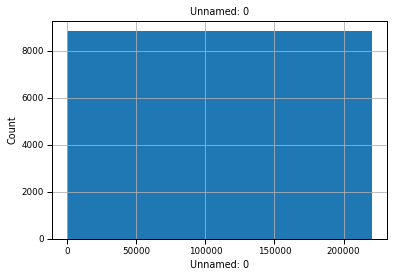

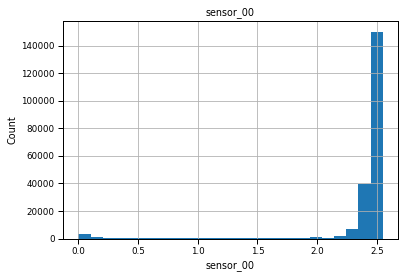

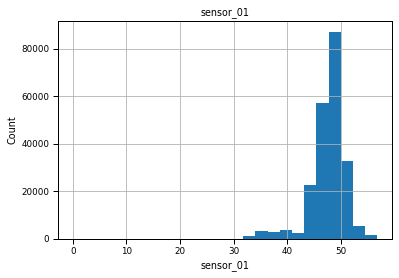

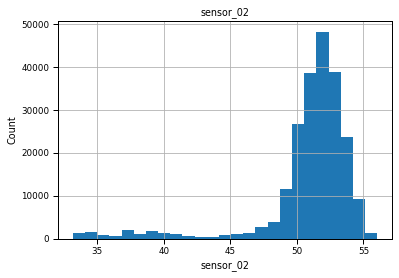

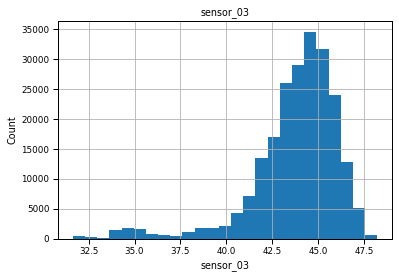

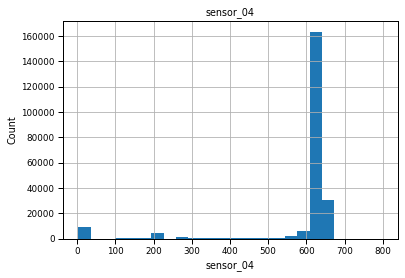

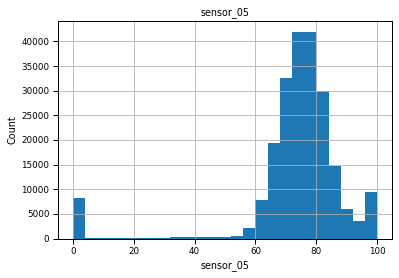

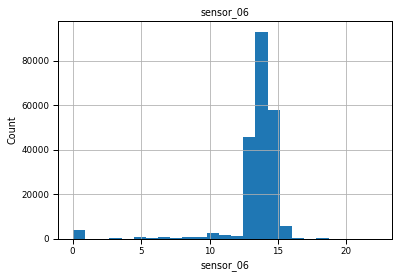

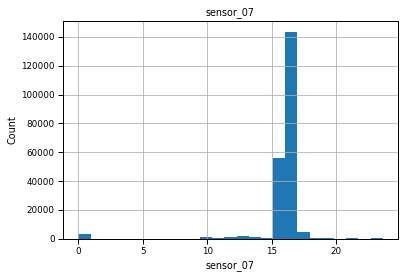

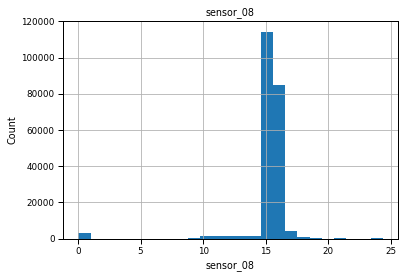

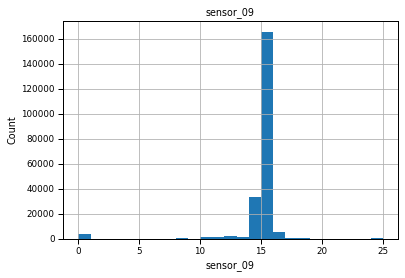

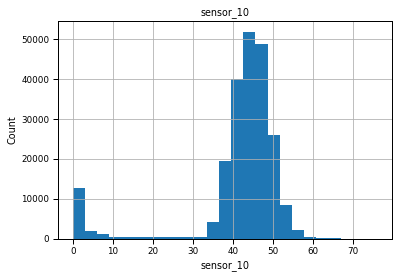

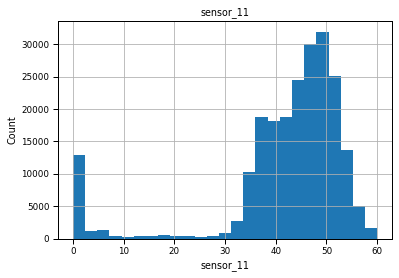

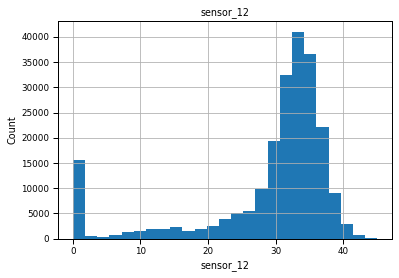

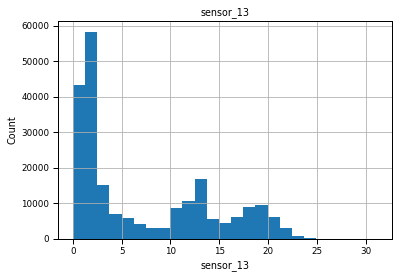

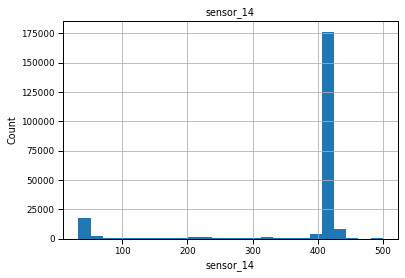

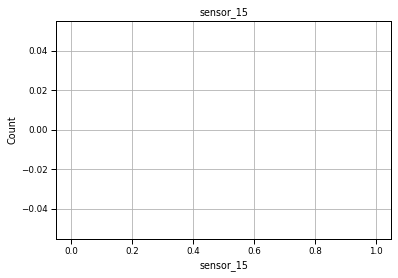

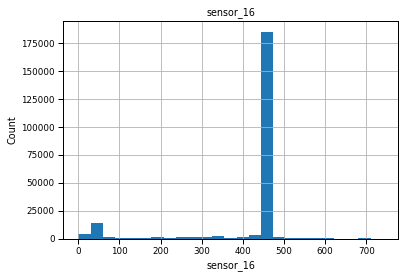

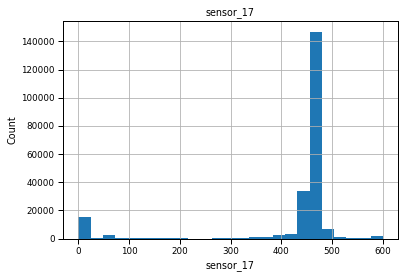

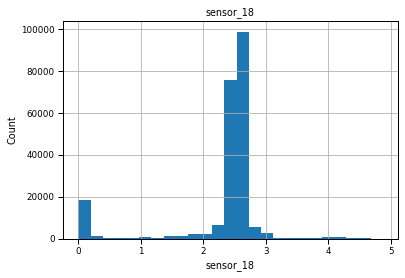

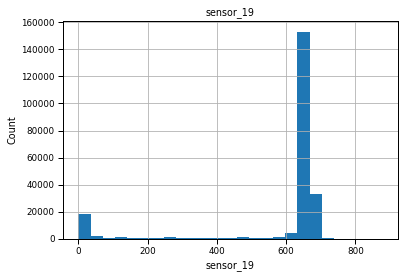

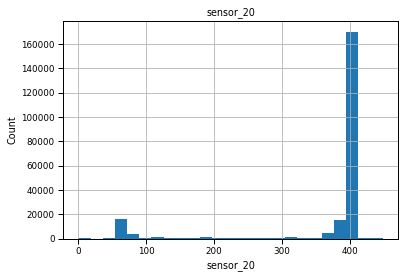

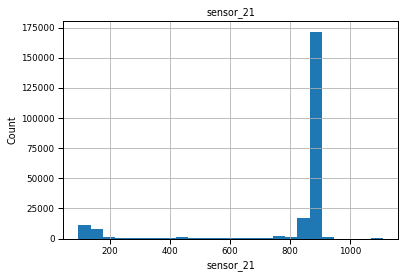

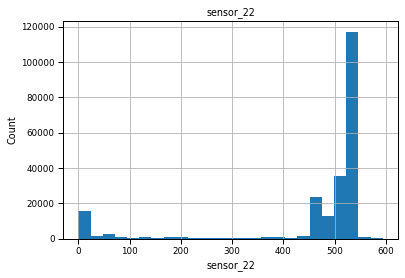

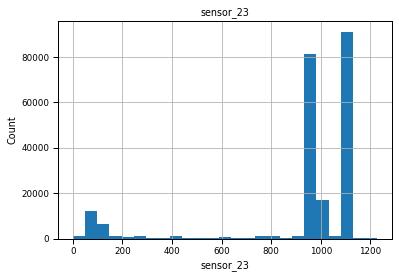

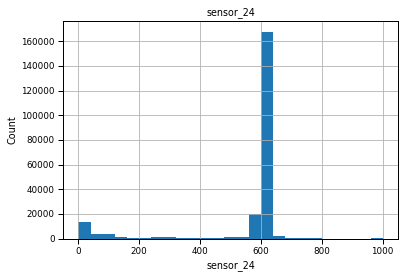

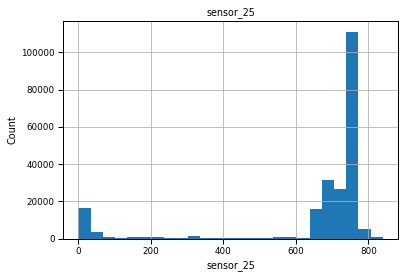

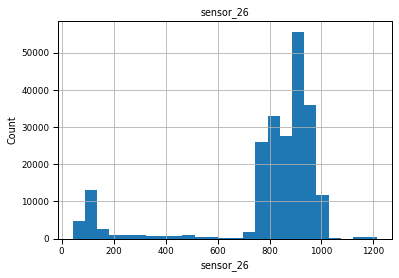

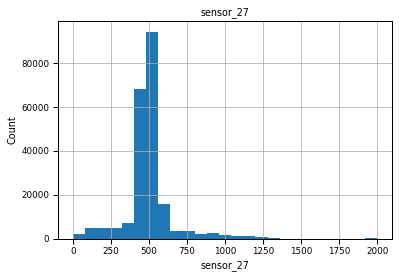

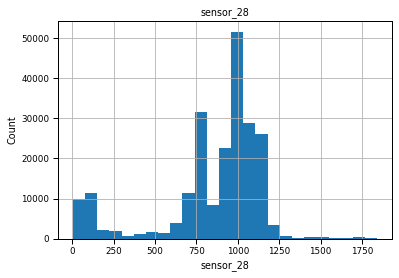

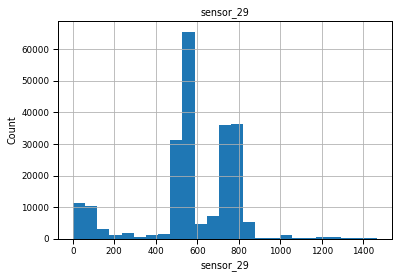

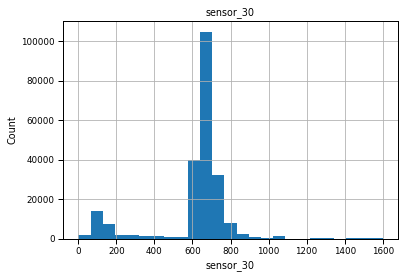

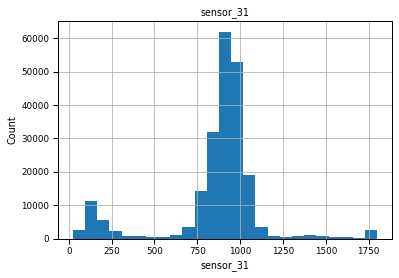

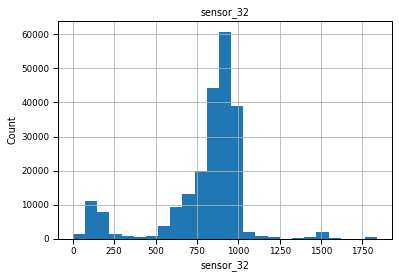

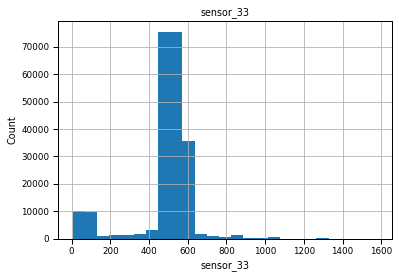

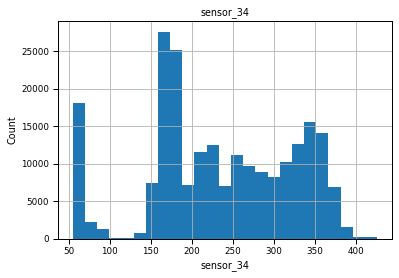

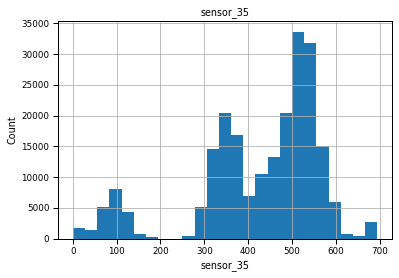

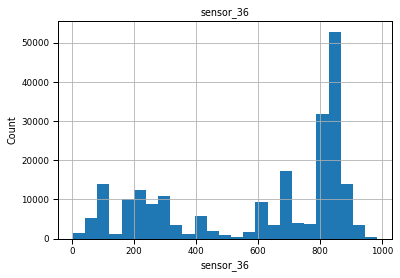

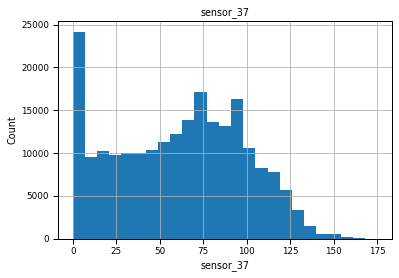

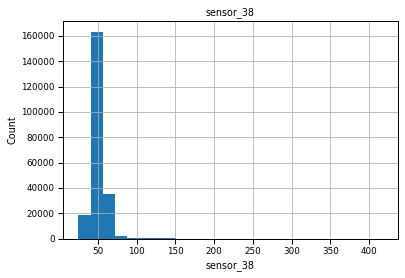

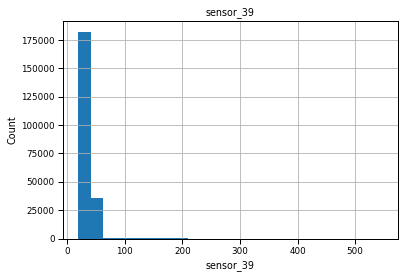

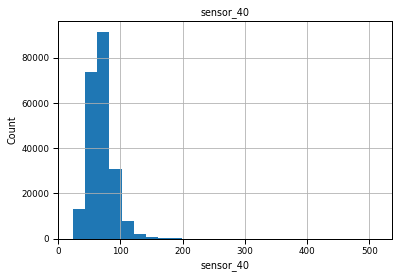

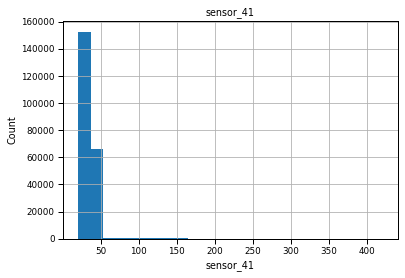

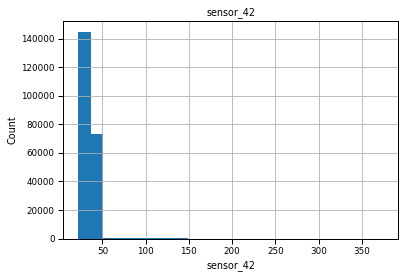

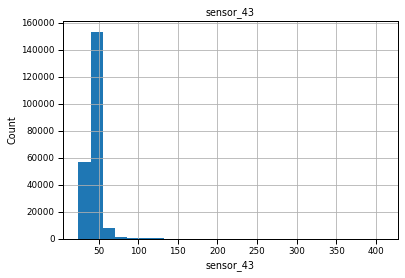

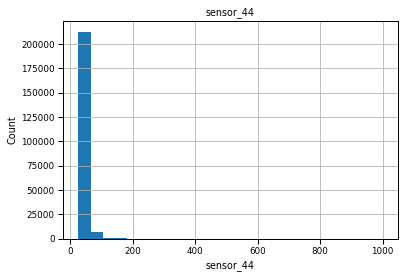

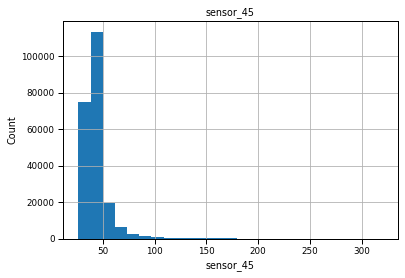

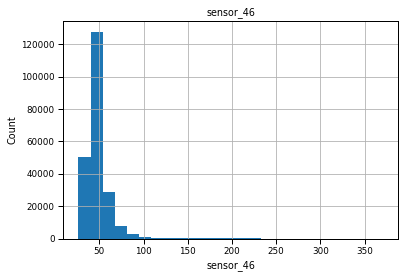

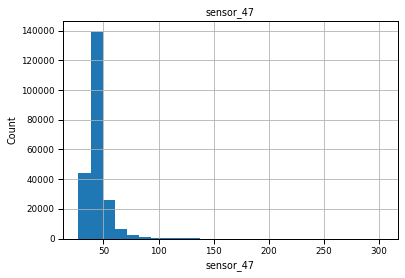

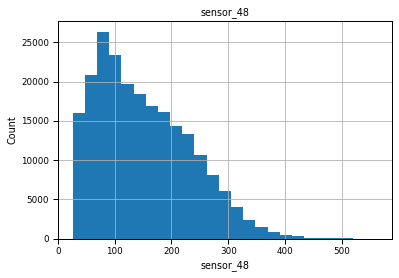

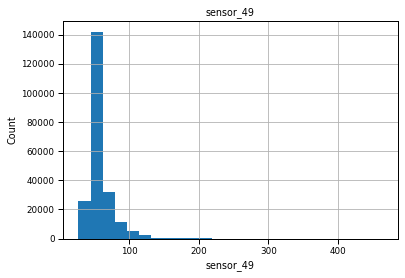

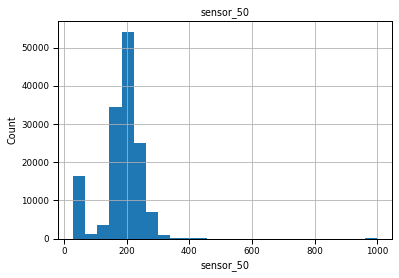

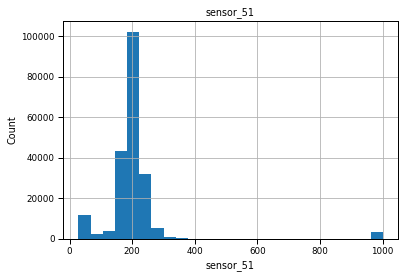

In [80]:
# Since sensor data are continues values, we use histogram to understand the distribution
for feature in Numerical_features:
    data=dataset.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

We can see that we have the three distributions; i.e., normal, skewed left\right.
The distribution should be semi\normal after handling missing data and outliers, which we'll do at the preprocessing stage.
We also see that some features have alomst the same distribution. one can attribute this to the fact that in actual operation, pump systems are equipped with multi sensors for the same operating parameter, such as pressure, temperature, etc. for a couple of reasons such as system reliability, safety and so on. 
This also can cause measured signals' overlapping as seen next:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb57fd5a810>,
      dtype=object)

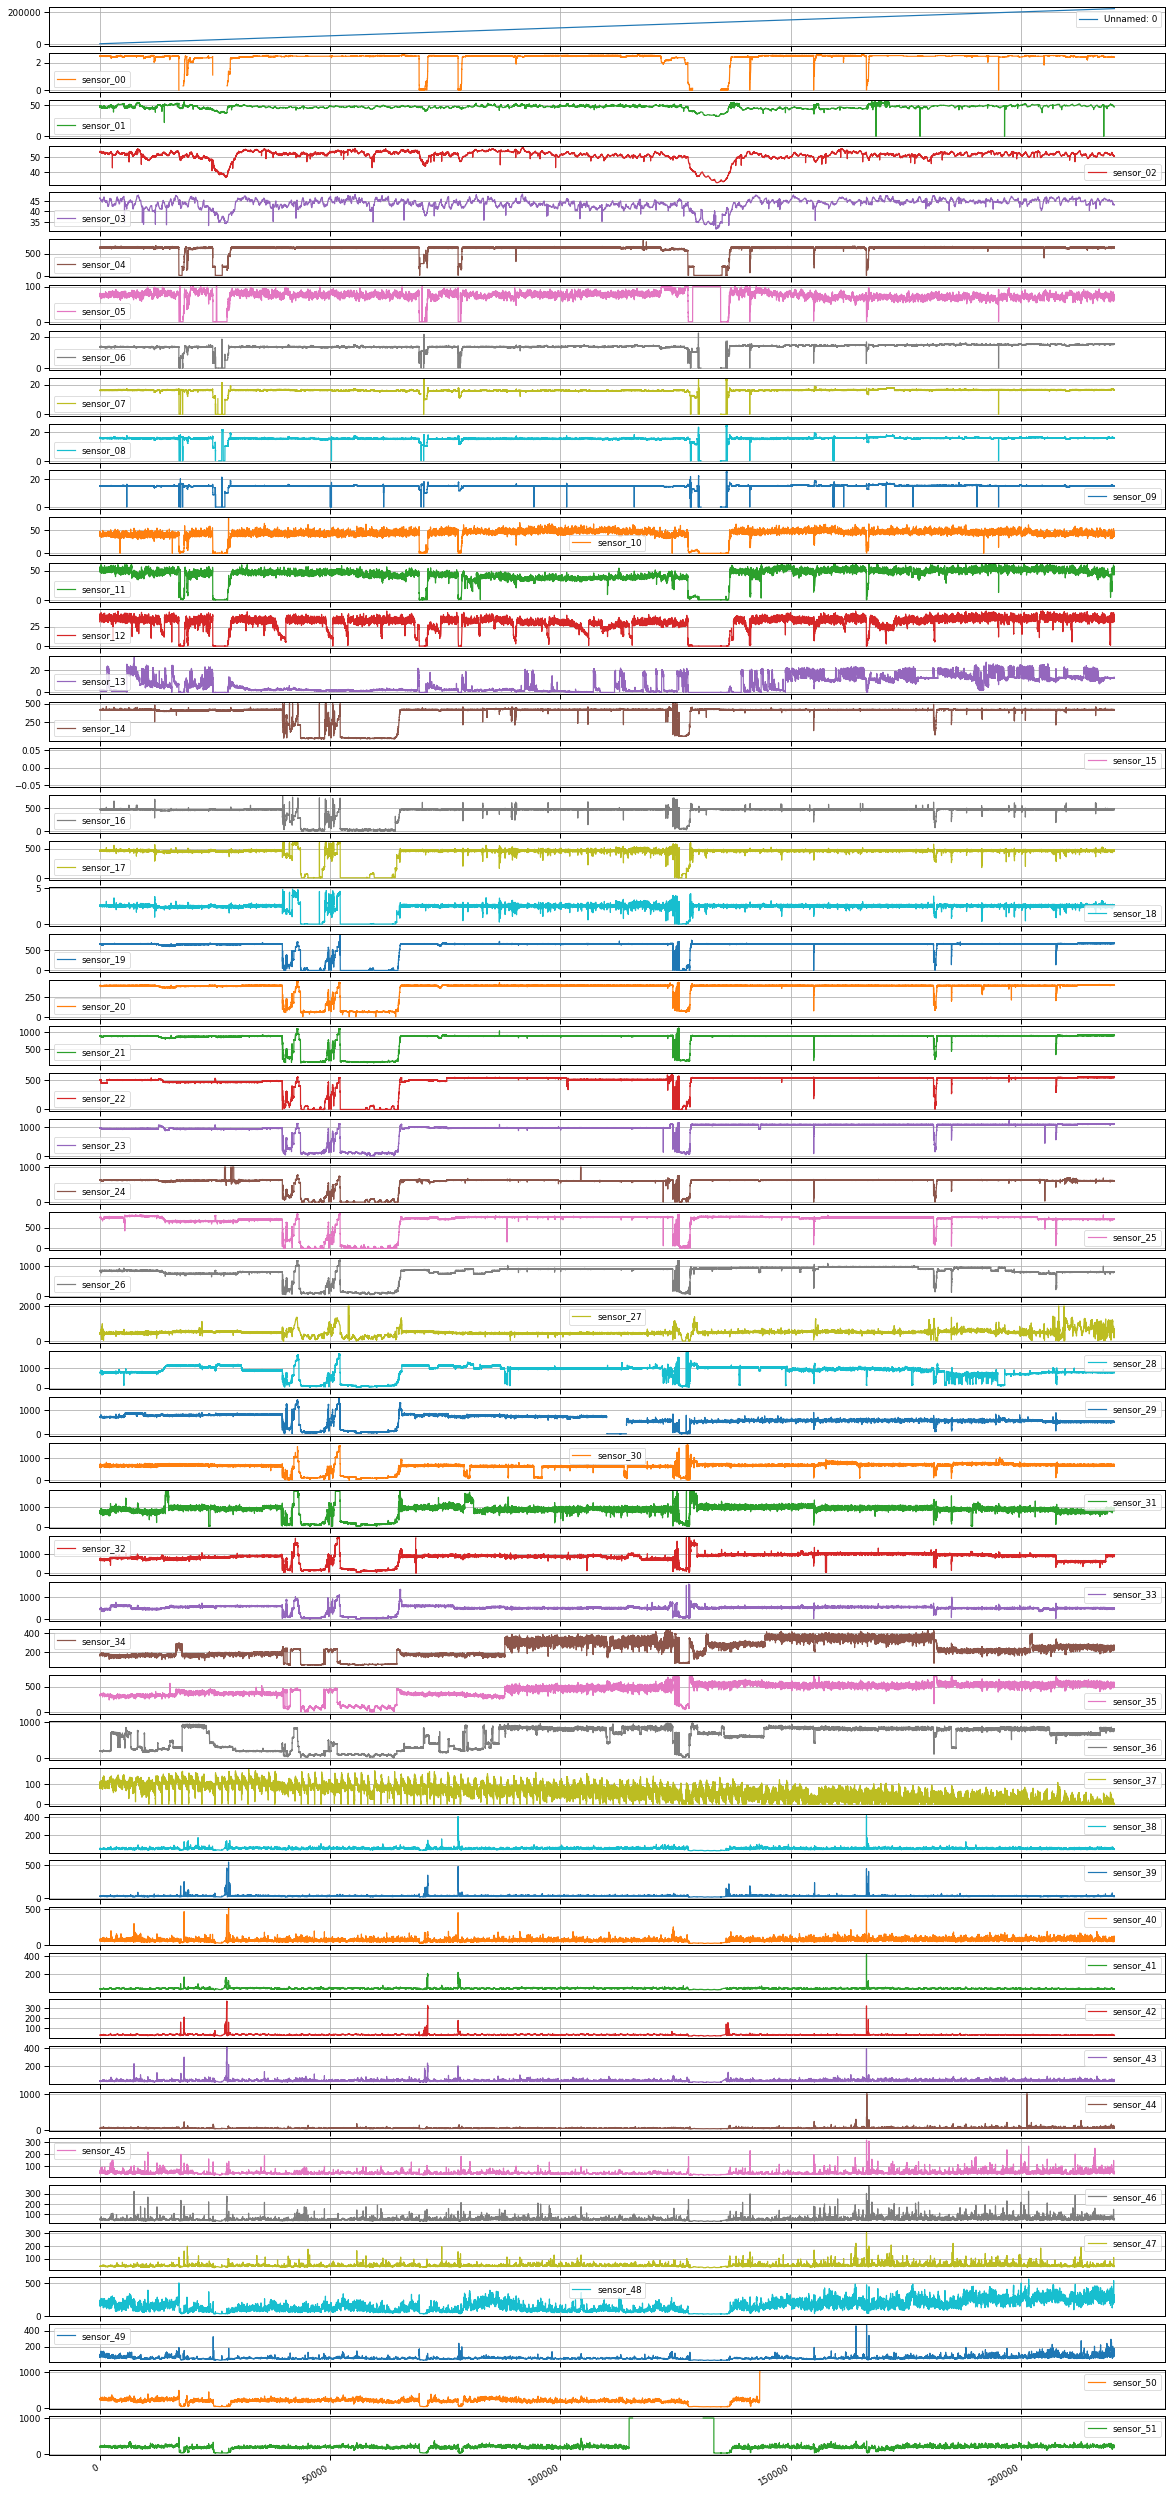

In [81]:
dataset.plot(subplots =True, sharex = True, figsize = (20,50))

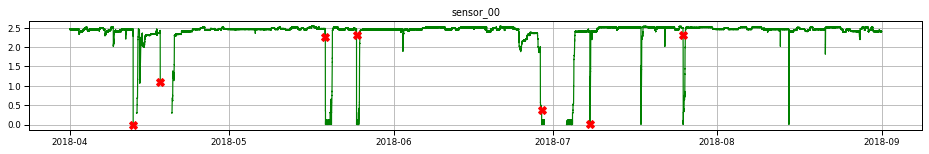

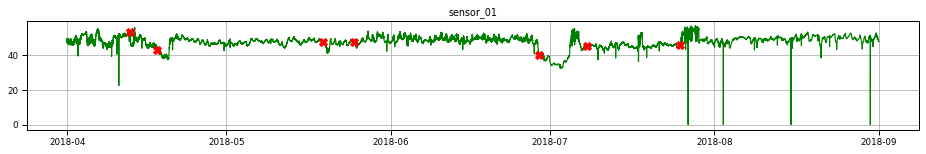

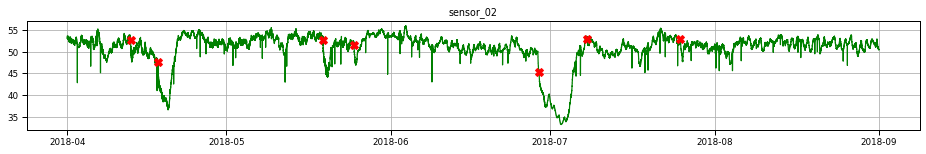

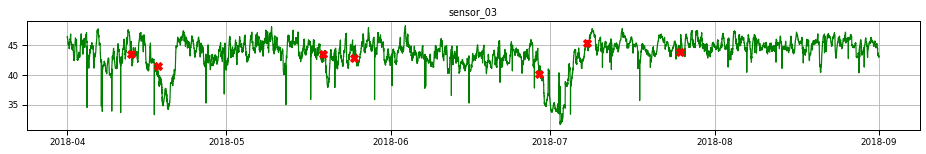

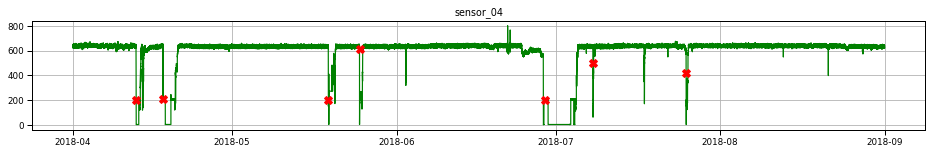

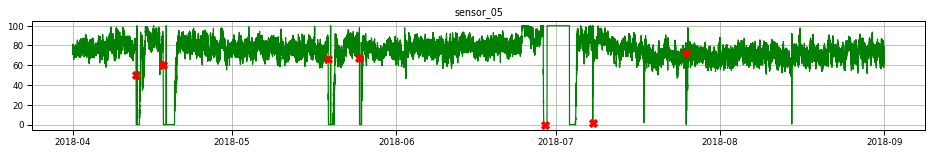

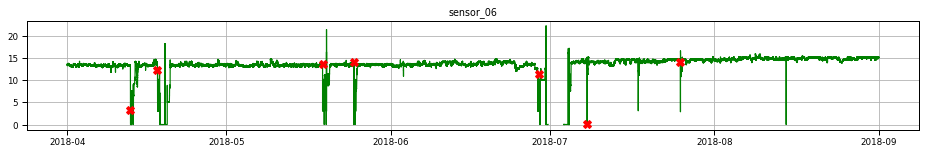

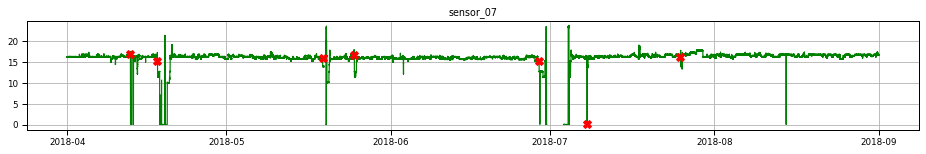

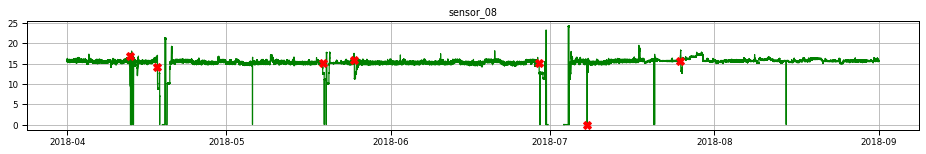

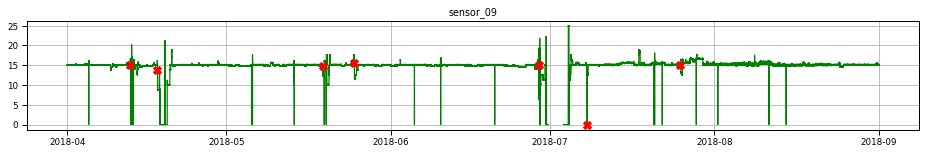

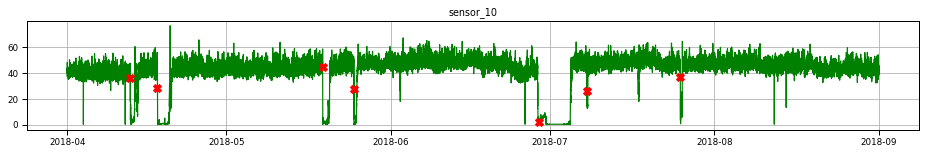

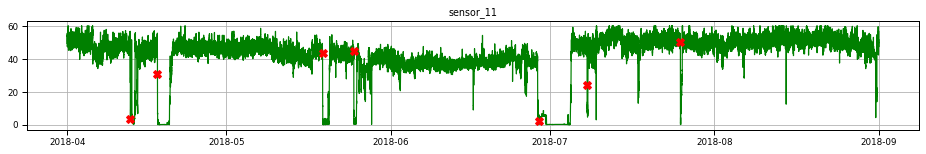

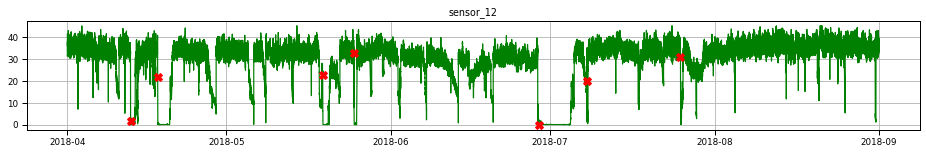

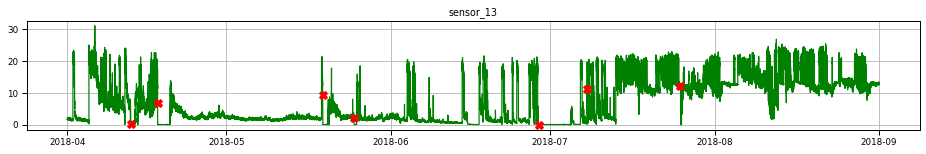

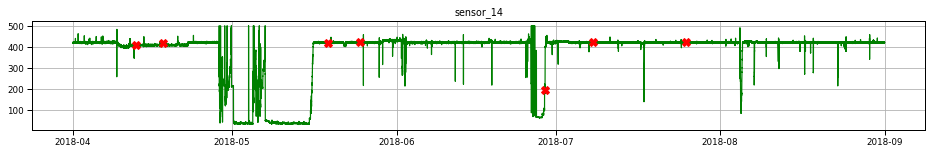

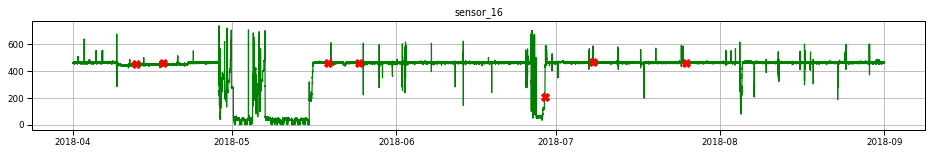

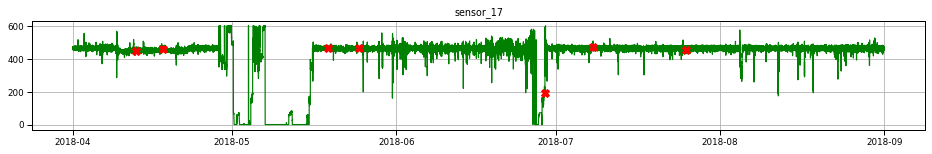

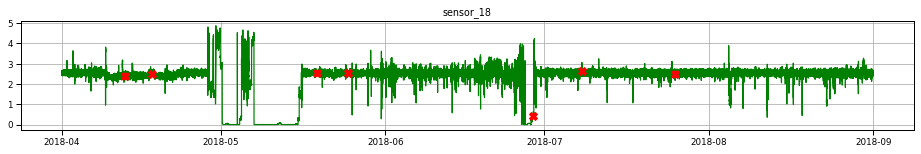

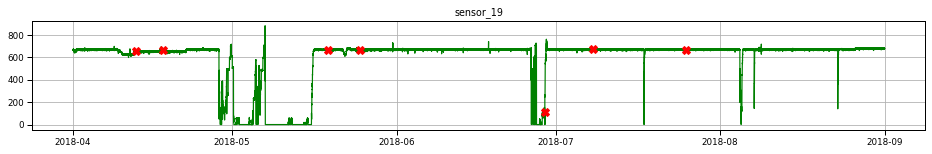

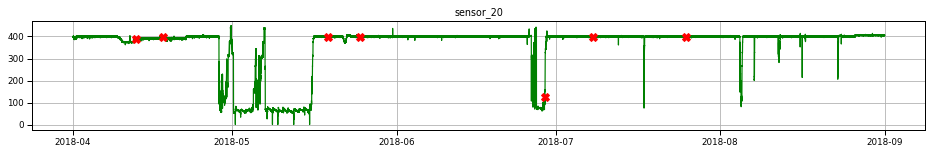

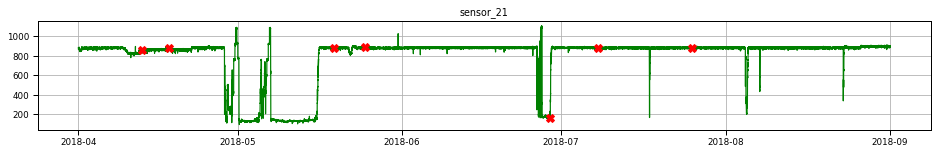

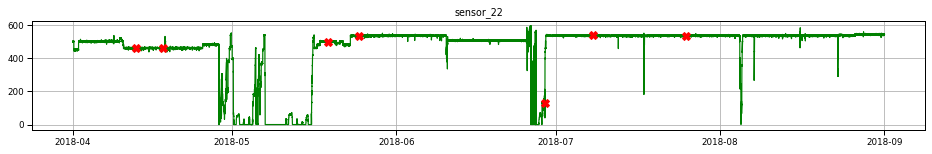

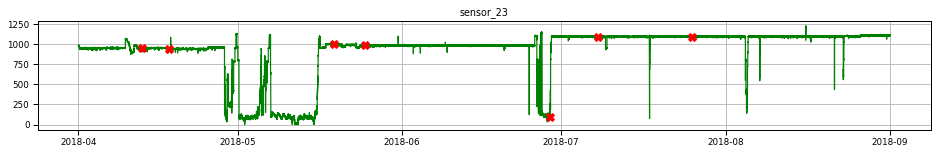

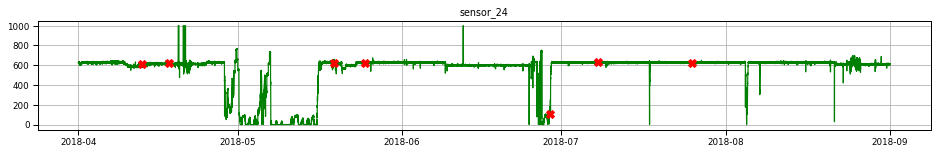

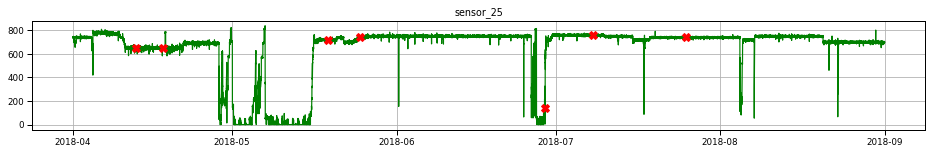

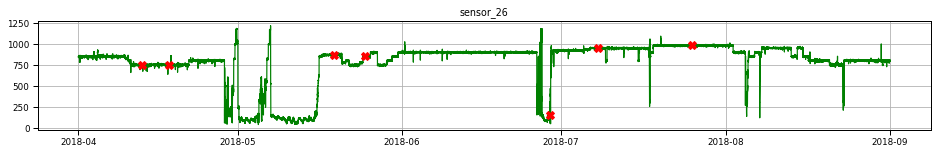

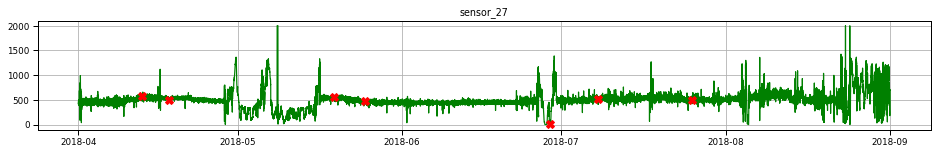

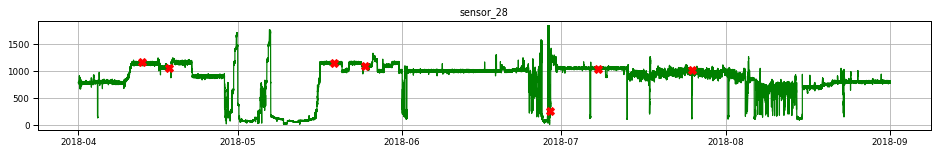

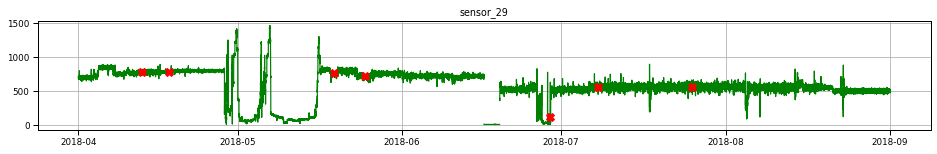

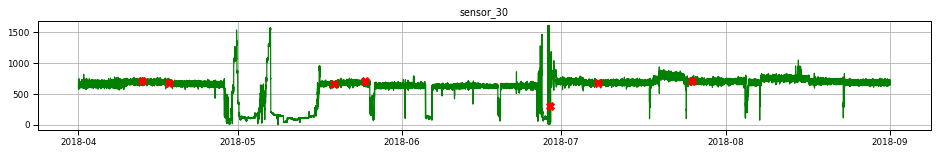

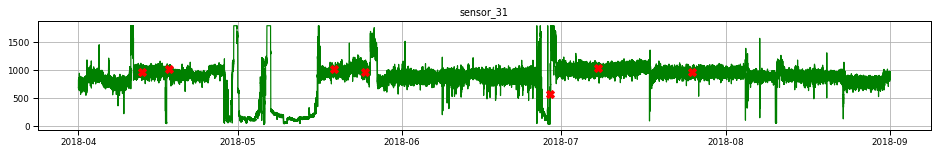

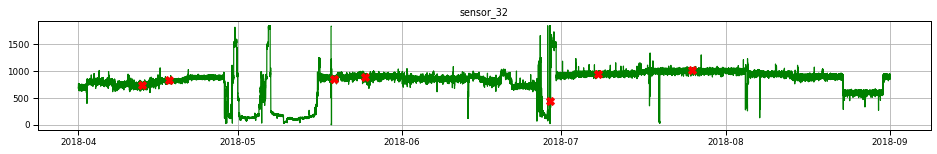

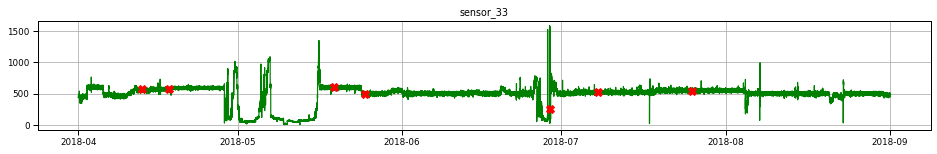

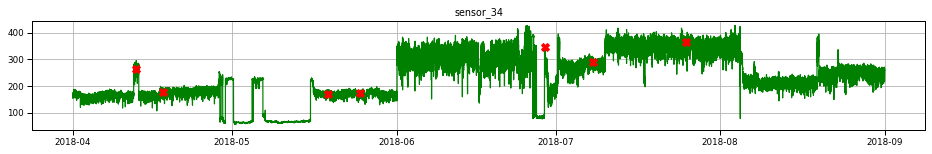

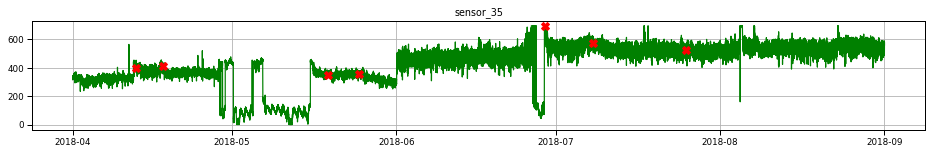

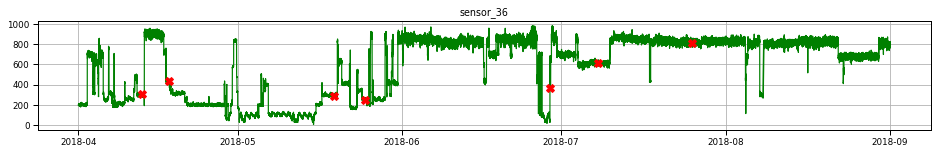

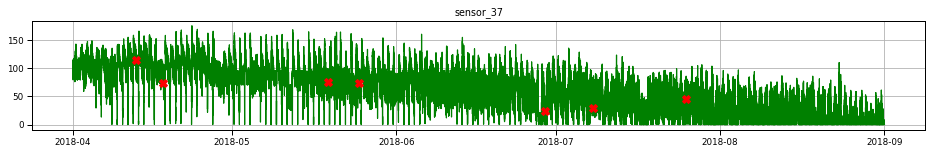

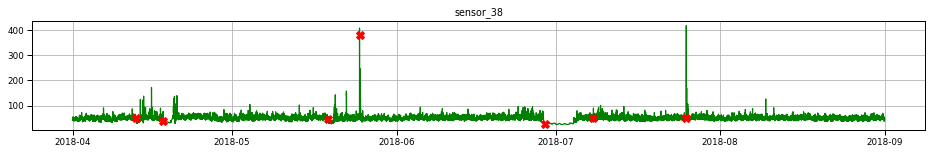

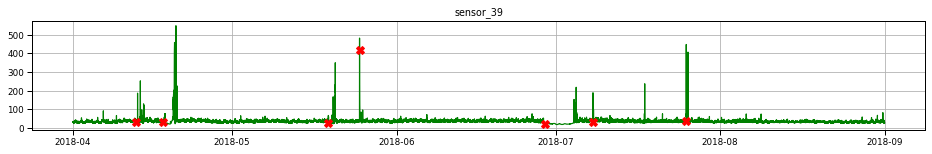

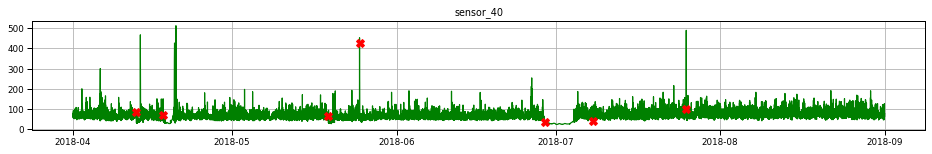

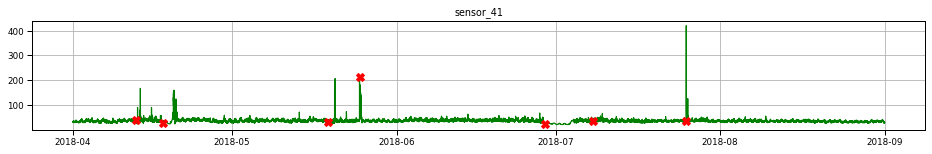

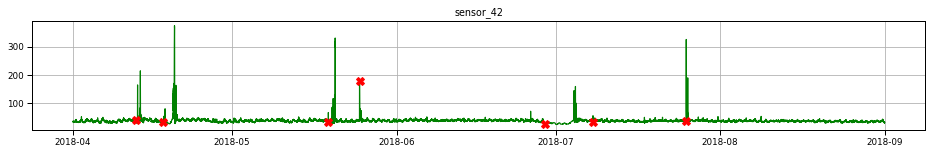

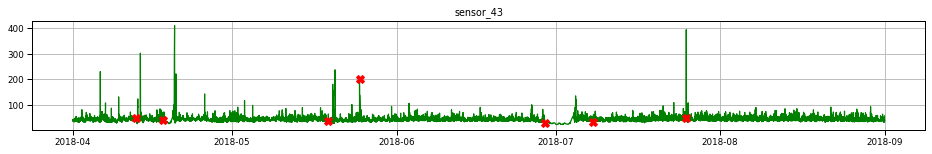

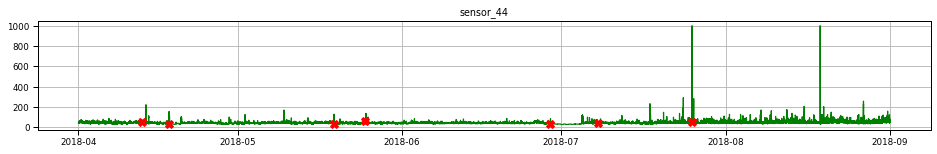

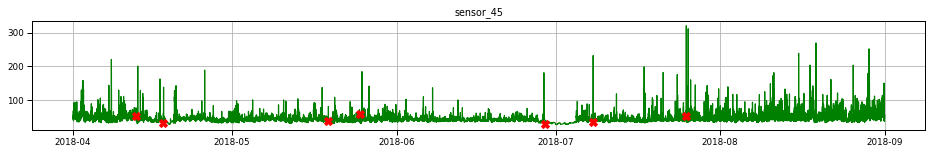

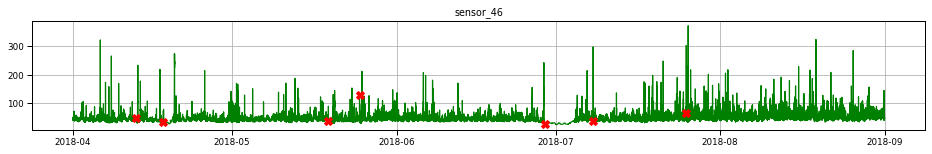

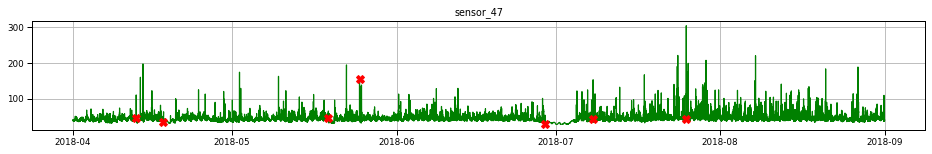

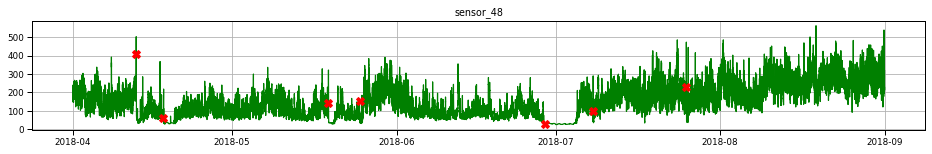

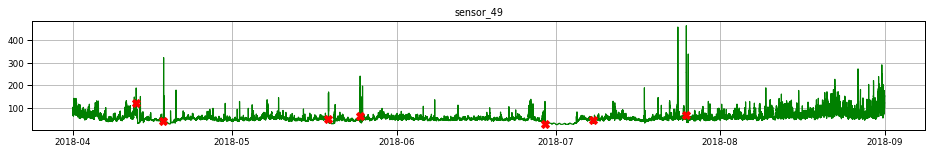

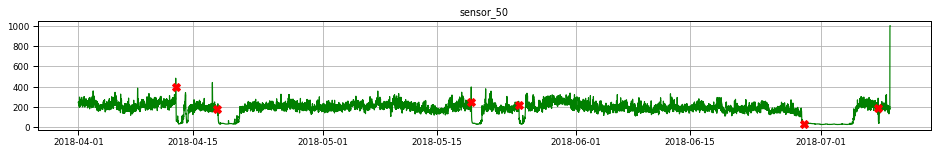

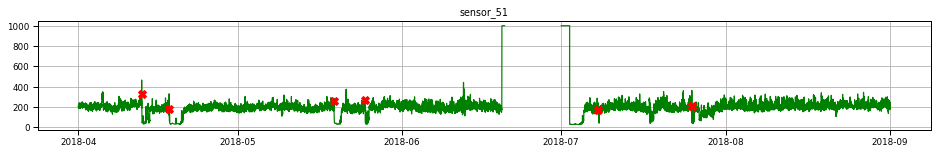

In [82]:
#Try to detect trends in sensors when the machine gets broken
#This will help us in feature selection later
df = dataset.drop(['Unnamed: 0','sensor_15'], axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace= True)

df_broken = df[df['machine_status']=='BROKEN']
df_sensors = df.drop(['machine_status'], axis=1)
sensors = df_sensors.columns

for sensor in sensors:
    sns.set_context('paper')
    _ = plt.figure(figsize=(16,2))
    _ = plt.plot(df[sensor], color='green')
    _ = plt.plot(df_broken[sensor], linestyle='none', marker='X', color='red', markersize=8)   
    _ = plt.title(sensor)
    plt.show()

It seems that sensors <b>{0,4,5,6,7,10,11,12,13}</b> correlate a lot with the failure of the machine and can be a good indicator of the failure of the system. We'll store this information to use later at the feature selection step.

In [83]:
sensors_with_trends = ['sensor_00','sensor_04','sensor_05','sensor_06','sensor_07','sensor_10','sensor_11','sensor_12','sensor_13']

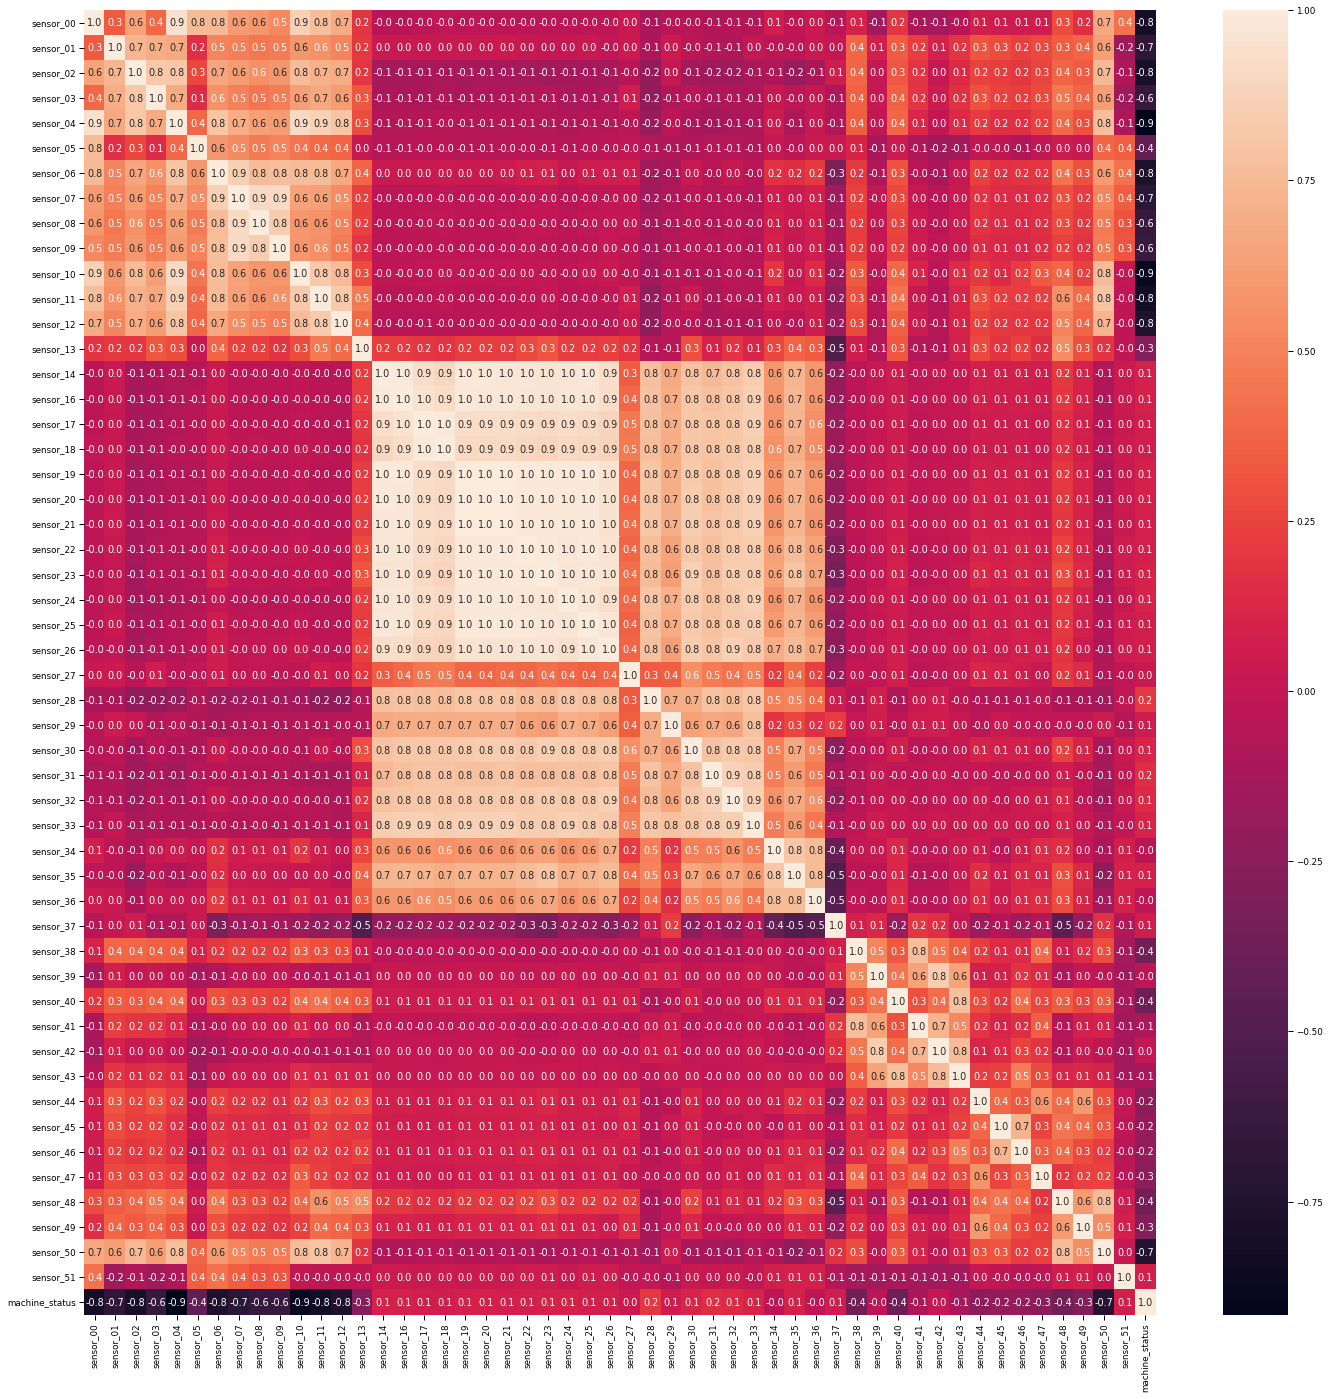

In [84]:
#Plot the whole raw dataset to detect correlation between sensors and target, also multicollinearity if any. 
#This information also will help us in feature selecting later.
#label encode machine status to be able to plot it along with the other numeric sensors

df = dataset.drop(['Unnamed: 0','sensor_15'], axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace= True)

df['machine_status'] = df['machine_status'].map({'NORMAL': 0, 'BROKEN': 1, 'RECOVERING':1})

#df.dtypes
corr = df.corr()
plt.figure(figsize=(24,24))
sns.heatmap(corr, annot=True, fmt = '.1f')


- There is a strong correlation exists between sensor_14 to sensor_26, sensor_28 to sensor_33 and sensor_34 to sensor_36.
- Multicollinearity should be handled, otherwise ML model performance will decrease.
- machine_status is highly negative correlated with sensor_01 to sensor_12.

### All Features:
- Missing Values: calculate NAN% in each var to decide whether to drop the feature or filling it with the proper strategy
- Duplicates
- Outliers: detect Outliers with(boxplot, IQR) 
- Correlation between independent and dependent feature(machine_status)

### Finding Missing Values (NAN %):

In [85]:
#As we've seen above, we only have two categorical features; machine_status and timestamp.
#Neither one of them has missing values. so here we'll concentrate only on numerical variables.
#Get Null Precentage in each column. I think % is more readable, but the plain view is fine as well.

features_with_na=[features for features in Numerical_features.columns if Numerical_features[features].isna().sum()>1]
na_percent = round(Numerical_features[features_with_na].isna().sum() * 100 / len(Numerical_features),2)
missing_percent_df = pd.DataFrame({'Feature': features_with_na, 'Na%':na_percent})

#Sort based on null precentage in each feature
missing_percent_df.sort_values('Na%', inplace=True, ascending=False)
missing_percent_df

Feature     Na%
sensor_15  sensor_15  100.00
sensor_50  sensor_50   34.96
sensor_51  sensor_51    6.98
sensor_00  sensor_00    4.63
sensor_07  sensor_07    2.47
sensor_08  sensor_08    2.32
sensor_06  sensor_06    2.18
sensor_09  sensor_09    2.09
sensor_01  sensor_01    0.17
sensor_30  sensor_30    0.12
sensor_29  sensor_29    0.03
sensor_32  sensor_32    0.03
sensor_17  sensor_17    0.02
sensor_22  sensor_22    0.02
sensor_25  sensor_25    0.02
sensor_18  sensor_18    0.02
sensor_39  sensor_39    0.01
sensor_04  sensor_04    0.01
sensor_38  sensor_38    0.01
sensor_37  sensor_37    0.01
sensor_36  sensor_36    0.01
sensor_40  sensor_40    0.01
sensor_43  sensor_43    0.01
sensor_41  sensor_41    0.01
sensor_42  sensor_42    0.01
sensor_34  sensor_34    0.01
sensor_44  sensor_44    0.01
sensor_45  sensor_45    0.01
sensor_46  sensor_46    0.01
sensor_47  sensor_47    0.01
sensor_48  sensor_48    0.01
sensor_49  sensor_49    0.01
sensor_02  sensor_02    0.01
sensor_35  sensor_35    0.01
sensor_28  sensor_28    0.01
sensor_33  sensor_33    0.01
sensor_16  sensor_16    0.01
sensor_10  sensor_10    0.01
sensor_11  sensor_11    0.01
sensor_12  sensor_12    0.01
sensor_13  sensor_13    0.01
sensor_14  sensor_14    0.01
sensor_03  sensor_03    0.01
sensor_19  sensor_19    0.01
sensor_31  sensor_31    0.01
sensor_20  sensor_20    0.01
sensor_21  sensor_21    0.01
sensor_23  sensor_23    0.01
sensor_24  sensor_24    0.01
sensor_27  sensor_27    0.01
sensor_05  sensor_05    0.01
sensor_26  sensor_26    0.01

### Finding Duplicates:

In [86]:
#look for duplicated rows based on timestamp column
#false == all rows are unique rows == no duplicate rows
boolean = not dataset["timestamp"].is_unique
boolean

False

### Finding Outliers:

Identified outliers: 0
Non-outlier observations: 220320
Outliers in Unnamed: 0 : 0.0 %


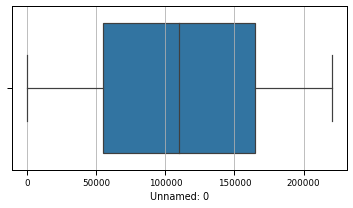

Identified outliers: 19995
Non-outlier observations: 190117
Outliers in sensor_00 : 9.08 %


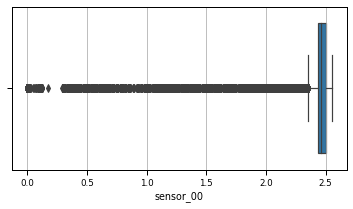

Identified outliers: 13484
Non-outlier observations: 206467
Outliers in sensor_01 : 6.12 %


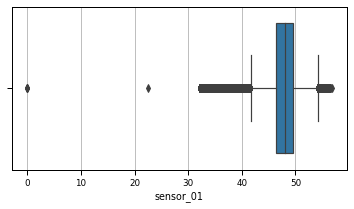

Identified outliers: 15486
Non-outlier observations: 204815
Outliers in sensor_02 : 7.03 %


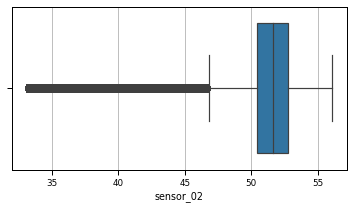

Identified outliers: 10723
Non-outlier observations: 209578
Outliers in sensor_03 : 4.87 %


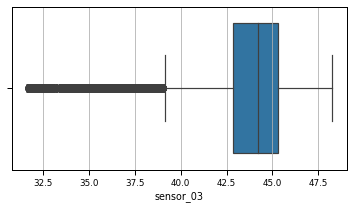

Identified outliers: 27237
Non-outlier observations: 193064
Outliers in sensor_04 : 12.36 %


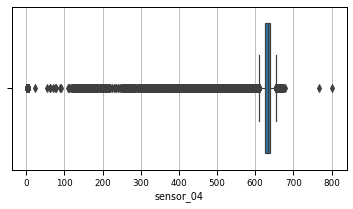

Identified outliers: 19359
Non-outlier observations: 200942
Outliers in sensor_05 : 8.79 %


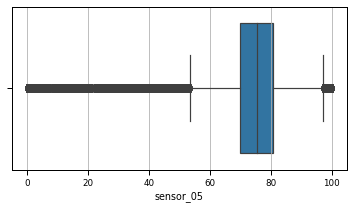

Identified outliers: 11750
Non-outlier observations: 203772
Outliers in sensor_06 : 5.33 %


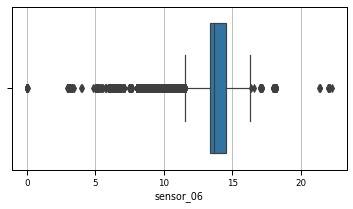

Identified outliers: 13809
Non-outlier observations: 201060
Outliers in sensor_07 : 6.27 %


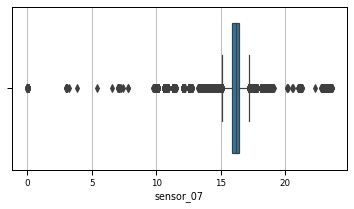

Identified outliers: 15797
Non-outlier observations: 199416
Outliers in sensor_08 : 7.17 %


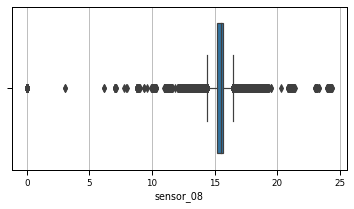

Identified outliers: 68761
Non-outlier observations: 146964
Outliers in sensor_09 : 31.21 %


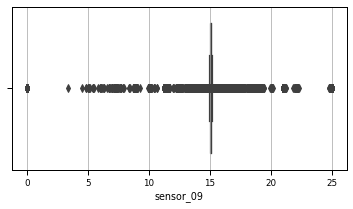

Identified outliers: 18815
Non-outlier observations: 201486
Outliers in sensor_10 : 8.54 %


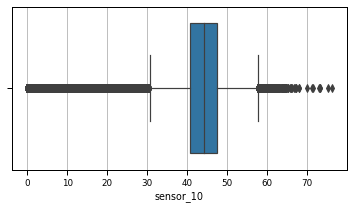

Identified outliers: 17873
Non-outlier observations: 202428
Outliers in sensor_11 : 8.11 %


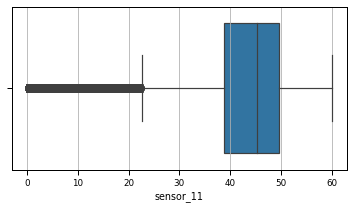

Identified outliers: 28683
Non-outlier observations: 191618
Outliers in sensor_12 : 13.02 %


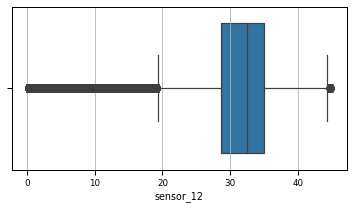

Identified outliers: 3
Non-outlier observations: 220298
Outliers in sensor_13 : 0.0 %


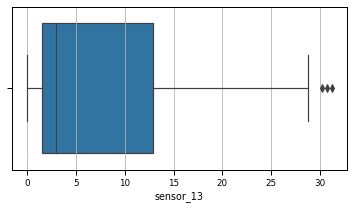

Identified outliers: 58154
Non-outlier observations: 162145
Outliers in sensor_14 : 26.4 %


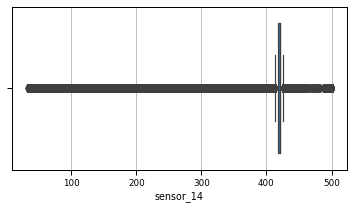

Identified outliers: 0
Non-outlier observations: 0
Outliers in sensor_15 : 0.0 %


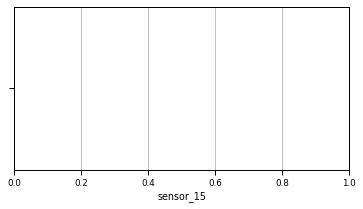

Identified outliers: 48815
Non-outlier observations: 171474
Outliers in sensor_16 : 22.16 %


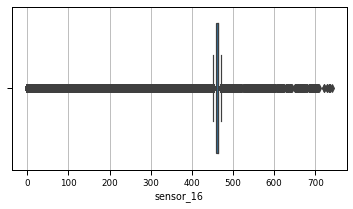

Identified outliers: 37938
Non-outlier observations: 182336
Outliers in sensor_17 : 17.22 %


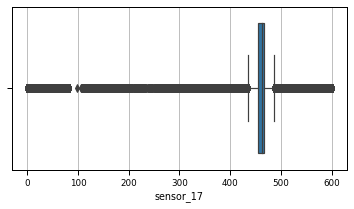

Identified outliers: 37883
Non-outlier observations: 182391
Outliers in sensor_18 : 17.19 %


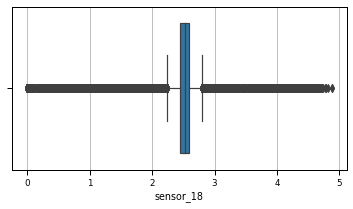

Identified outliers: 58108
Non-outlier observations: 162196
Outliers in sensor_19 : 26.37 %


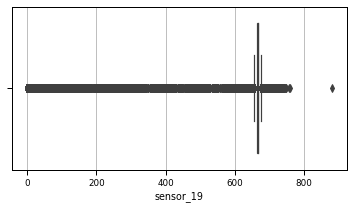

Identified outliers: 59580
Non-outlier observations: 160724
Outliers in sensor_20 : 27.04 %


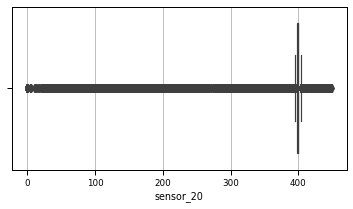

Identified outliers: 56063
Non-outlier observations: 164241
Outliers in sensor_21 : 25.45 %


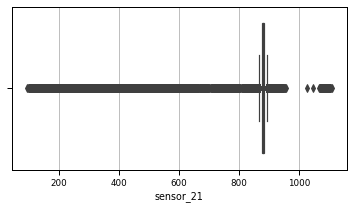

Identified outliers: 27939
Non-outlier observations: 192340
Outliers in sensor_22 : 12.68 %


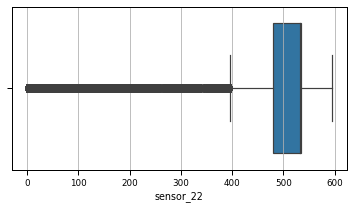

Identified outliers: 26198
Non-outlier observations: 194106
Outliers in sensor_23 : 11.89 %


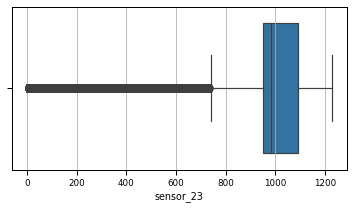

Identified outliers: 31013
Non-outlier observations: 189291
Outliers in sensor_24 : 14.08 %


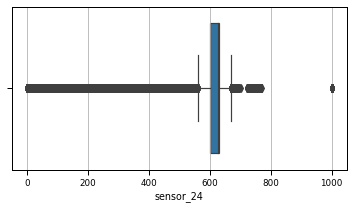

Identified outliers: 28480
Non-outlier observations: 191804
Outliers in sensor_25 : 12.93 %


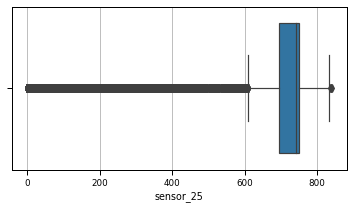

Identified outliers: 27931
Non-outlier observations: 192369
Outliers in sensor_26 : 12.68 %


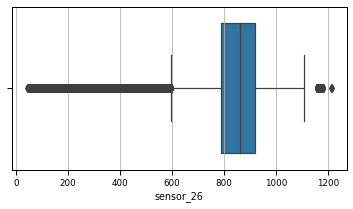

Identified outliers: 32756
Non-outlier observations: 187548
Outliers in sensor_27 : 14.87 %


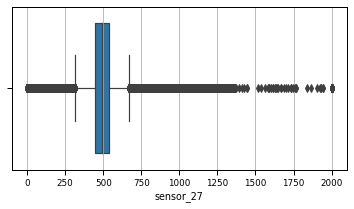

Identified outliers: 27652
Non-outlier observations: 192652
Outliers in sensor_28 : 12.55 %


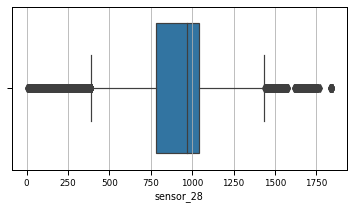

Identified outliers: 26430
Non-outlier observations: 193818
Outliers in sensor_29 : 12.0 %


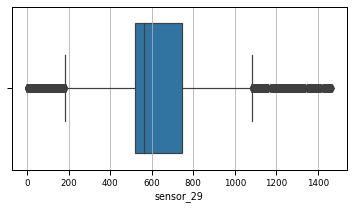

Identified outliers: 37156
Non-outlier observations: 182903
Outliers in sensor_30 : 16.86 %


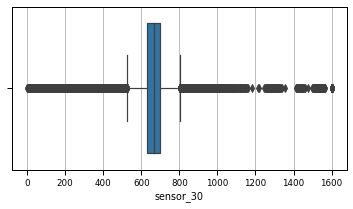

Identified outliers: 32613
Non-outlier observations: 187691
Outliers in sensor_31 : 14.8 %


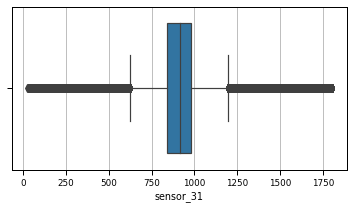

Identified outliers: 26781
Non-outlier observations: 193471
Outliers in sensor_32 : 12.16 %


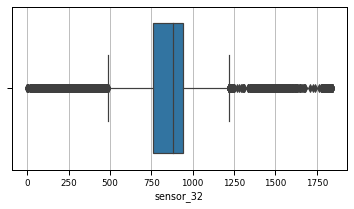

Identified outliers: 30005
Non-outlier observations: 190299
Outliers in sensor_33 : 13.62 %


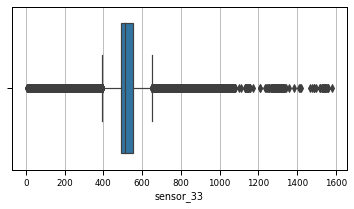

Identified outliers: 0
Non-outlier observations: 220304
Outliers in sensor_34 : 0.0 %


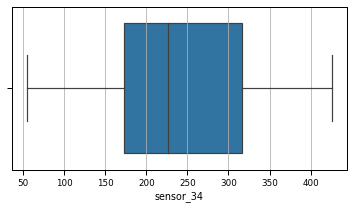

Identified outliers: 10185
Non-outlier observations: 210119
Outliers in sensor_35 : 4.62 %


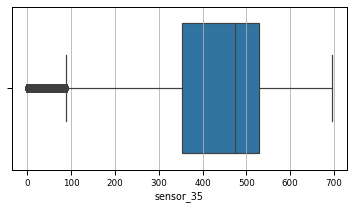

Identified outliers: 0
Non-outlier observations: 220304
Outliers in sensor_36 : 0.0 %


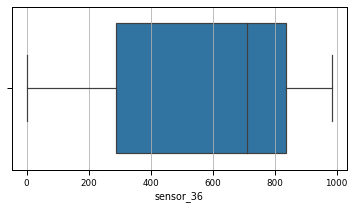

Identified outliers: 0
Non-outlier observations: 220304
Outliers in sensor_37 : 0.0 %


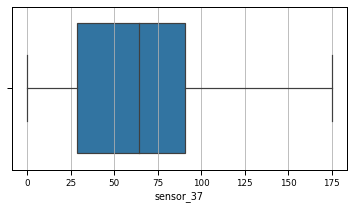

Identified outliers: 16212
Non-outlier observations: 204081
Outliers in sensor_38 : 7.36 %


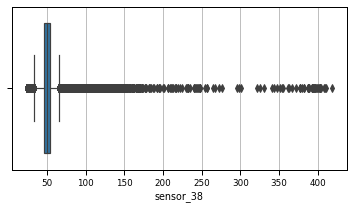

Identified outliers: 9084
Non-outlier observations: 211209
Outliers in sensor_39 : 4.12 %


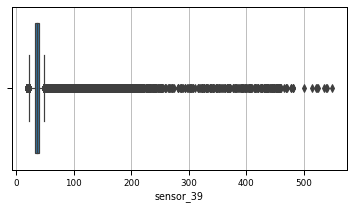

Identified outliers: 11447
Non-outlier observations: 208846
Outliers in sensor_40 : 5.2 %


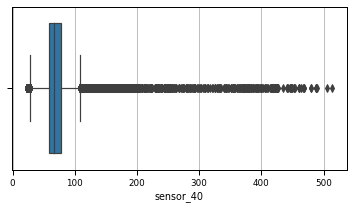

Identified outliers: 10223
Non-outlier observations: 210070
Outliers in sensor_41 : 4.64 %


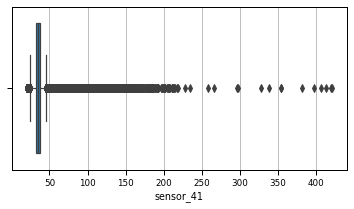

Identified outliers: 8539
Non-outlier observations: 211754
Outliers in sensor_42 : 3.88 %


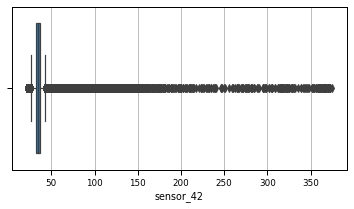

Identified outliers: 11723
Non-outlier observations: 208570
Outliers in sensor_43 : 5.32 %


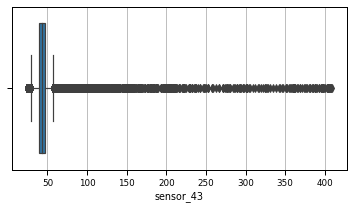

Identified outliers: 13114
Non-outlier observations: 207179
Outliers in sensor_44 : 5.95 %


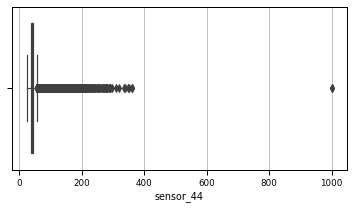

Identified outliers: 17024
Non-outlier observations: 203269
Outliers in sensor_45 : 7.73 %


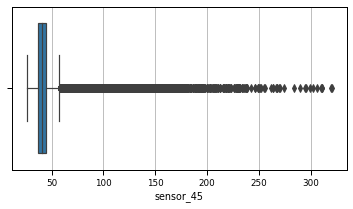

Identified outliers: 13761
Non-outlier observations: 206532
Outliers in sensor_46 : 6.25 %


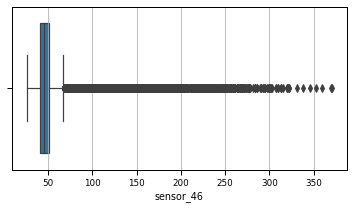

Identified outliers: 13584
Non-outlier observations: 206709
Outliers in sensor_47 : 6.17 %


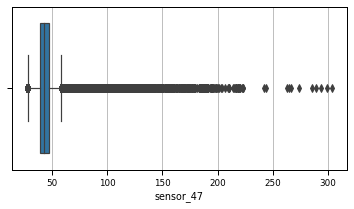

Identified outliers: 920
Non-outlier observations: 219373
Outliers in sensor_48 : 0.42 %


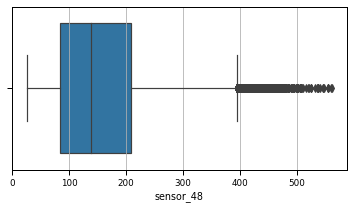

Identified outliers: 21413
Non-outlier observations: 198880
Outliers in sensor_49 : 9.72 %


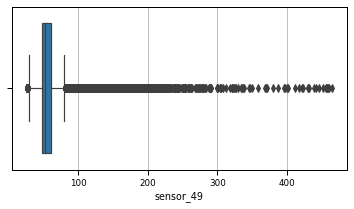

Identified outliers: 18588
Non-outlier observations: 124715
Outliers in sensor_50 : 8.44 %


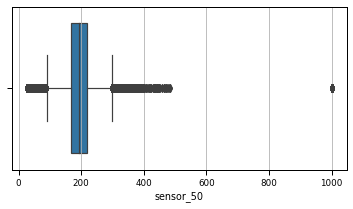

Identified outliers: 21828
Non-outlier observations: 183109
Outliers in sensor_51 : 9.91 %


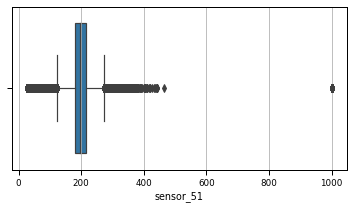

In [87]:
#since so many of our features have skewed distribution, we'll use IQR method to detect outliers in these features:
for feature in Numerical_features:  
    series = Numerical_features[feature]
    Q1 = series.quantile(0.25) 
    Q3 = series.quantile(0.75) 
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    outliers = [x for x in series if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    outliers_removed = [x for x in series if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(outliers_removed))
    print('Outliers in',feature,':', round(len(outliers) * 100 / len(series),2),'%')
    plt.figure(figsize=(6, 3))
    sns.boxplot(x= series)
    plt.show()

### Thoughts:

We know that our numeric features are sensors data, and we expected there will be outliers due to the fact that these sensors are working in a real enviroment and it is inevitable that some sensor nodes malfunction, which may result in noisy, faulty, missing and redundant data. Also the low cost and low quality sensor nodes have firm resource constraints such as energy (battery power), memory, computational capacity and communication bandwidth. The limited resource and capability affect the reliablity and the accuracy of the generated data. Especially when battery power is exhausted, the probability of generating erroneous data will grow rapidly. 

Even With that in mind, we're not sure if what appear as outliers in the plots are really outliers.
Could they be just part of the data? 

### Data Preprocessing
- Drop obvious null or irrelevant features
- Re-index dataset if needed
- Encode Label data: one-hot or label-encoding (in our case we choose label-enoding)
- Data Imputation: 
    - if numerical => constant Or statistics.
    - if categorical => constant or most-frequent.
    - if data has outliers, then median should be used as both mean and std. are affected greatly with the outliers.
- Handle Outliers by (we chose capping technique as we don't want to just trim them) 
- Data Scaling: we chose Robust Scaler just in case we still have outliers
- Remove Duplicates.
- Dataset Correlation
- Correlation between independent and target feature(machine_status): use this information later in feature selection

In [88]:
#drop sensor_15, Unnamed: 0
dataset.drop({'sensor_15','Unnamed: 0'},axis=1, inplace=True)

#convert timestamp to datetime 
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

#set timestamp as data index
dataset.set_index('timestamp', inplace= True)

### Label Encoding:

In [89]:
#Replace the categorical value with a numeric value. 
#NORMAL is mapped to 0, RECOVERING and BROKEN are mapped to 1.
#We'll ue mapping here instead of LabelEncoder

dataset['machine_status'] = dataset['machine_status'].map({'NORMAL': 0, 'BROKEN': 1, 'RECOVERING':1})

In [90]:
dataset['machine_status'].value_counts()

0    205836
1     14484
Name: machine_status, dtype: int64

### Data Imputation
From plotting the features early in the EDA stage, clearly many of our data are skewed, plus there are many outlies. therefore we will use median value to fill in the missing values:

In [91]:
#Filling missing numerical values with median
#first drop sensor_15 from features_with_na list
features_with_na.remove('sensor_15')
median_series = dataset[features_with_na].median()
dataset[features_with_na] = dataset[features_with_na].fillna(median_series)

In [92]:
#Double check the whole dataframe again
na_values = dataset[features_with_na].isna().sum()
not all(na_values) #If true ==> no missing values anymore.

True

### Handle Outliers (Via Capping):

In [93]:
#1. Cap ouliers in all features
for feature in dataset[features_with_na]:  
    percentiles = dataset[feature].quantile([0.25, 0.75]).values
    dataset[feature][dataset[feature] <= percentiles[0]] = percentiles[0]
    dataset[feature][dataset[feature] >= percentiles[1]] = percentiles[1]

Outliers in sensor_00 : 0.0 %


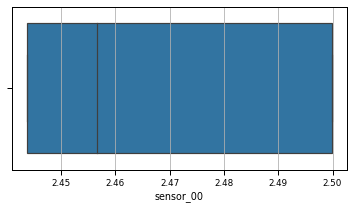

Outliers in sensor_01 : 0.0 %


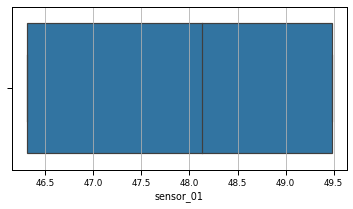

Outliers in sensor_02 : 0.0 %


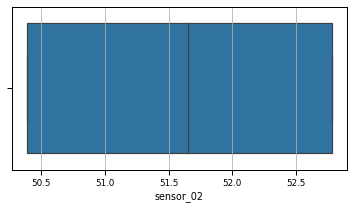

Outliers in sensor_03 : 0.0 %


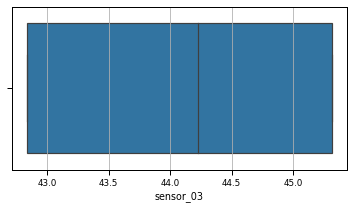

Outliers in sensor_04 : 0.0 %


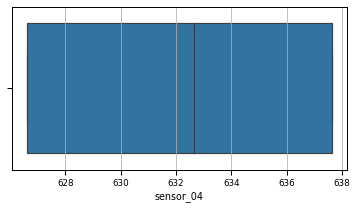

Outliers in sensor_05 : 0.0 %


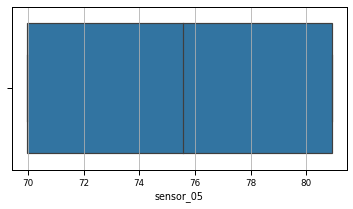

Outliers in sensor_06 : 0.0 %


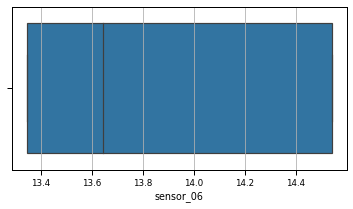

Outliers in sensor_07 : 0.0 %


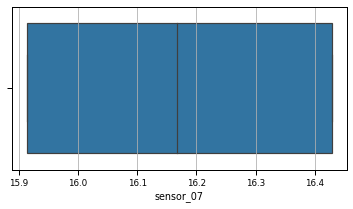

Outliers in sensor_08 : 0.0 %


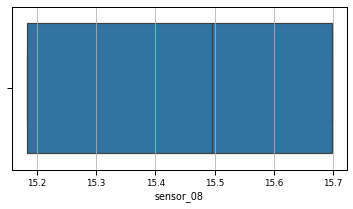

Outliers in sensor_09 : 0.0 %


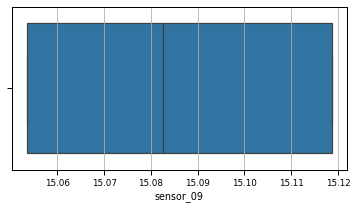

Outliers in sensor_10 : 0.0 %


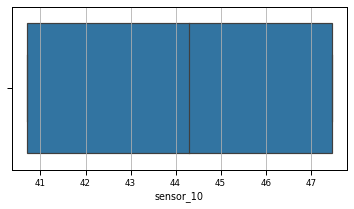

Outliers in sensor_11 : 0.0 %


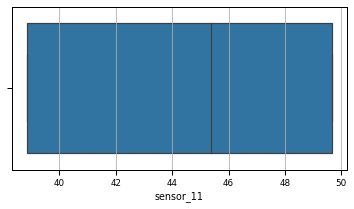

Outliers in sensor_12 : 0.0 %


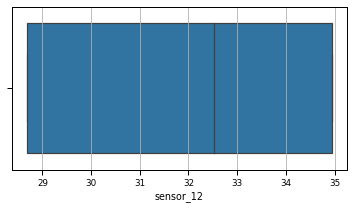

Outliers in sensor_13 : 0.0 %


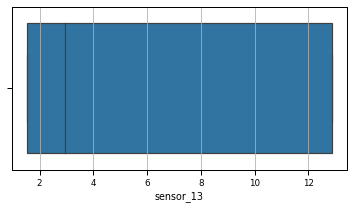

Outliers in sensor_14 : 0.0 %


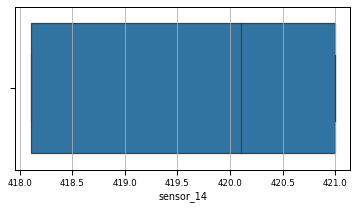

Outliers in sensor_16 : 0.0 %


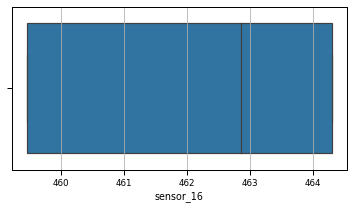

Outliers in sensor_17 : 0.0 %


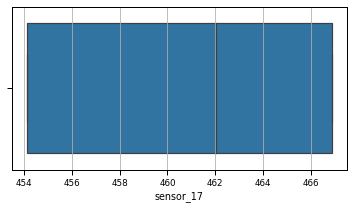

Outliers in sensor_18 : 0.0 %


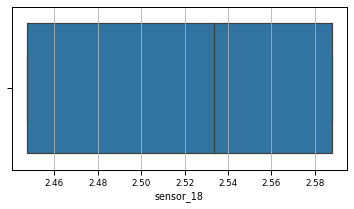

Outliers in sensor_19 : 0.0 %


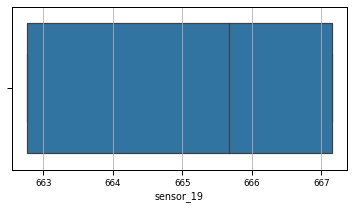

Outliers in sensor_20 : 0.0 %


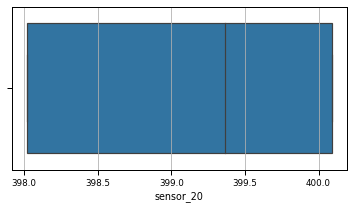

Outliers in sensor_21 : 0.0 %


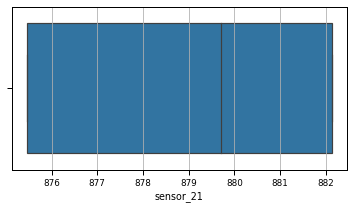

Outliers in sensor_22 : 0.0 %


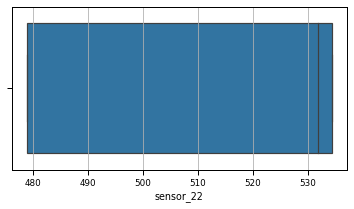

Outliers in sensor_23 : 0.0 %


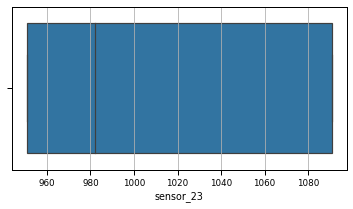

Outliers in sensor_24 : 0.0 %


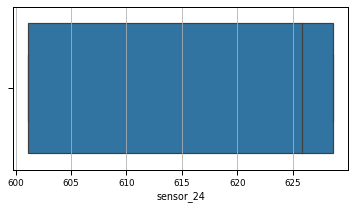

Outliers in sensor_25 : 0.0 %


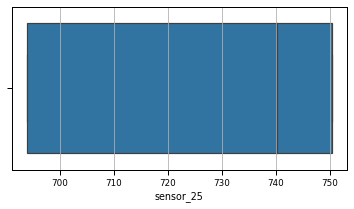

Outliers in sensor_26 : 0.0 %


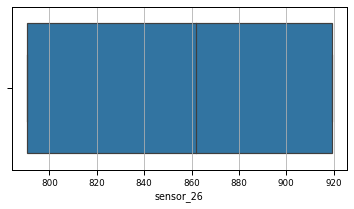

Outliers in sensor_27 : 0.0 %


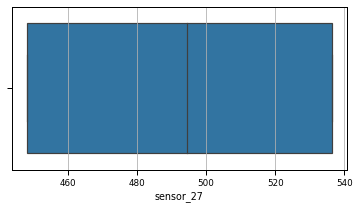

Outliers in sensor_28 : 0.0 %


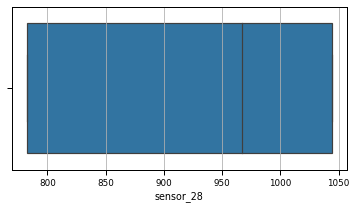

Outliers in sensor_29 : 0.0 %


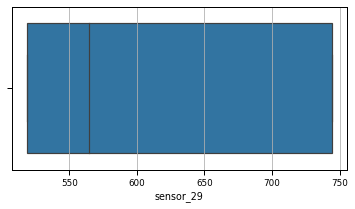

Outliers in sensor_30 : 0.0 %


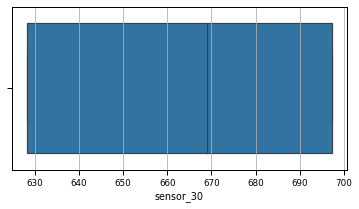

Outliers in sensor_31 : 0.0 %


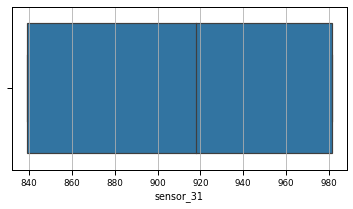

Outliers in sensor_32 : 0.0 %


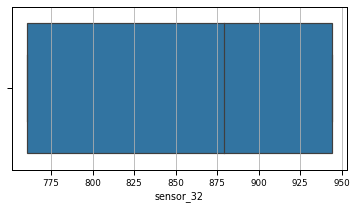

Outliers in sensor_33 : 0.0 %


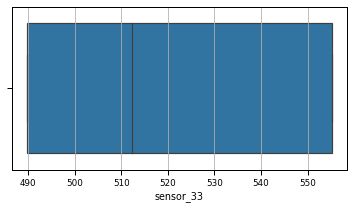

Outliers in sensor_34 : 0.0 %


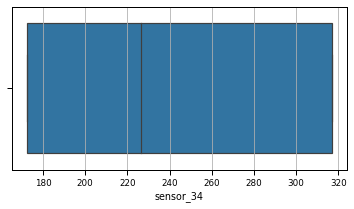

Outliers in sensor_35 : 0.0 %


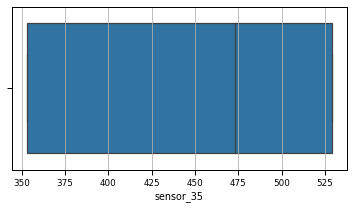

Outliers in sensor_36 : 0.0 %


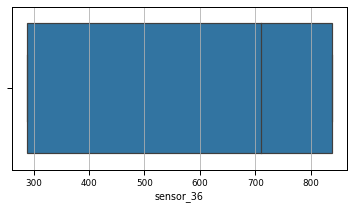

Outliers in sensor_37 : 0.0 %


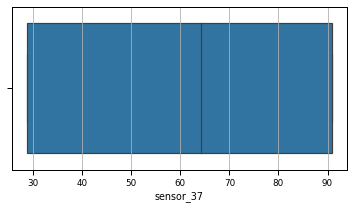

Outliers in sensor_38 : 0.0 %


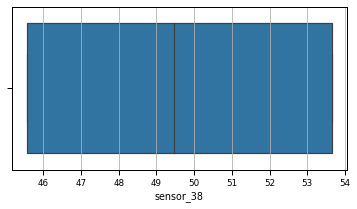

Outliers in sensor_39 : 0.0 %


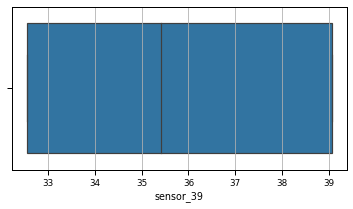

Outliers in sensor_40 : 0.0 %


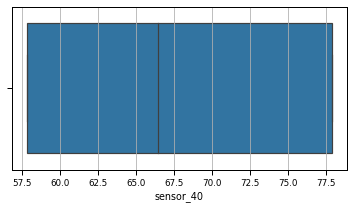

Outliers in sensor_41 : 0.0 %


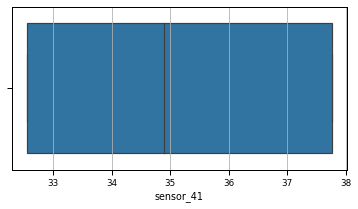

Outliers in sensor_42 : 0.0 %


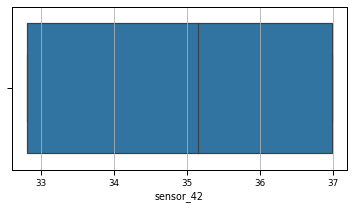

Outliers in sensor_43 : 0.0 %


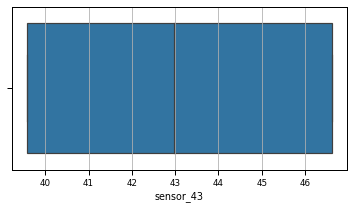

Outliers in sensor_44 : 0.0 %


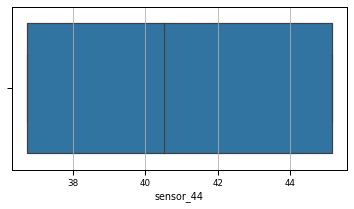

Outliers in sensor_45 : 0.0 %


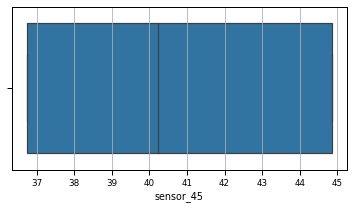

Outliers in sensor_46 : 0.0 %


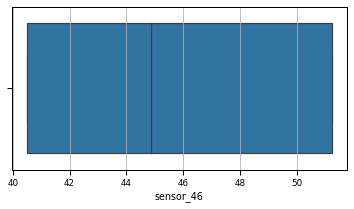

Outliers in sensor_47 : 0.0 %


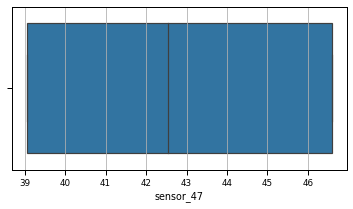

Outliers in sensor_48 : 0.0 %


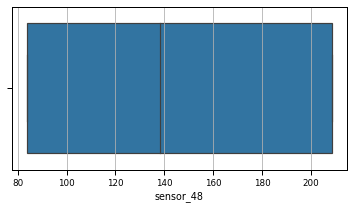

Outliers in sensor_49 : 0.0 %


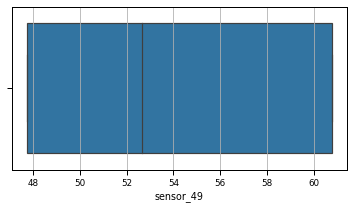

Outliers in sensor_50 : 0.0 %


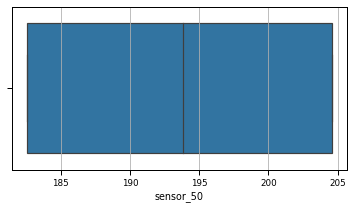

Outliers in sensor_51 : 0.0 %


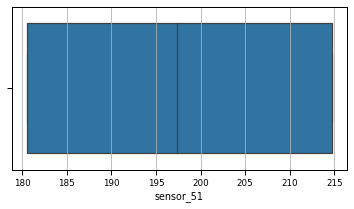

In [94]:
#2. plot features after capping to see the effect
for feature in dataset[features_with_na]:    
    Q1 = dataset[feature].quantile(0.25) 
    Q3 = dataset[feature].quantile(0.75) 
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    outliers = [y for y in dataset[feature] if y < lower or y > upper]
    print('Outliers in',feature,':', round(len(outliers) * 100 / len(dataset[feature]),2),'%')
    plt.figure(figsize=(6, 3))
    sns.boxplot(x= dataset[feature])
    plt.show()

### Data Scaling:
Our features varies largly in their scales, therefore scaling them is a neccessity to prepare our data to be fed to ML model later.
We'll use Robust Scaler.

In [95]:
scaler = preprocessing.RobustScaler()
dataset[features_with_na] = scaler.fit_transform(dataset[features_with_na])
dataset[features_with_na].describe()

sensor_00      sensor_01      sensor_02      sensor_03  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean        0.188902      -0.052509      -0.016969      -0.043589   
std         0.408329       0.402859       0.404268       0.403330   
min        -0.228065      -0.575343      -0.527273      -0.561403   
25%        -0.228065      -0.575343      -0.527273      -0.561403   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.771935       0.424657       0.472727       0.438597   
max         0.771935       0.424657       0.472727       0.438597   

           sensor_04      sensor_05      sensor_06      sensor_07  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.028351      -0.007858       0.177660       0.009333   
std         0.403611       0.404802       0.404944       0.384504   
min        -0.547371      -0.512104      -0.248488      -0.492952   
25%        -0.547371      -0.512096      -0.248488      -0.492952   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.452629       0.487904       0.751512       0.507048   
max         0.452629       0.487905       0.751512       0.507048   

           sensor_08      sensor_09      sensor_10      sensor_11  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.077657       0.046450      -0.020100      -0.069613   
std         0.420207       0.432092       0.405687       0.407742   
min        -0.605627      -0.444547      -0.530614      -0.602464   
25%        -0.605627      -0.444547      -0.530614      -0.602461   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.394373       0.555453       0.469386       0.397539   
max         0.394373       0.555453       0.469387       0.397539   

           sensor_12      sensor_13      sensor_14      sensor_16  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.071248       0.290002      -0.114758      -0.122253   
std         0.402073       0.440426       0.396994       0.398863   
min        -0.612365      -0.122887      -0.692113      -0.701605   
25%        -0.612362      -0.122886      -0.692106      -0.701605   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.387638       0.877114       0.307894       0.298395   
max         0.387641       0.877116       0.307894       0.298395   

           sensor_17      sensor_18      sensor_19      sensor_20  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.075749      -0.072899      -0.099001      -0.091110   
std         0.401204       0.401264       0.398377       0.397685   
min        -0.619671      -0.614804      -0.663198      -0.650956   
25%        -0.619669      -0.614802      -0.663194      -0.650956   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.380331       0.385198       0.336806       0.349044   
max         0.380331       0.385199       0.336811       0.349044   

           sensor_21      sensor_22      sensor_23      sensor_24  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.082596      -0.344996       0.256599      -0.289139   
std         0.398120       0.430545       0.446686       0.430116   
min        -0.635047      -0.956615      -0.221628      -0.900420   
25%        -0.635041      -0.956615      -0.221628      -0.900419   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.364959       0.043385       0.778372       0.099581   
max         0.364959       0.043385       0.778374       0.099581   

           sensor_25      sensor_26      sensor_27      sensor_28  \
count  220320.000000  220320.000000  220320.000000  220320.000000   
mean       -0.232791      -0.036717      -0.023854      -0.169013   
std         0.431574       0.425414       0.409046       0.422294   
min

### Remove Duplicates:

In [96]:
dataset.drop_duplicates()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
timestamp                                                                    
2018-04-01 00:00:00   0.157911  -0.328768   0.472727   0.438597   0.157893   
2018-04-01 00:02:00  -0.210518  -0.246575   0.472727   0.438597   0.452629   
2018-04-01 00:03:00   0.070173  -0.328768   0.472727   0.438597  -0.410531   
2018-04-01 00:04:00  -0.192970  -0.315070   0.472727   0.438597   0.347364   
2018-04-01 00:05:00  -0.052625  -0.328768   0.472727   0.438597   0.452627   
...                        ...        ...        ...        ...        ...   
2018-08-31 23:55:00  -0.228065  -0.136987  -0.472727  -0.438595   0.189473   
2018-08-31 23:56:00  -0.228065  -0.136987  -0.454542  -0.438595  -0.157899   
2018-08-31 23:57:00  -0.228065  -0.136987  -0.472727  -0.438595  -0.547371   
2018-08-31 23:58:00  -0.228065  -0.136987  -0.472726  -0.438595   0.273679   
2018-08-31 23:59:00  -0.228065  -0.136987  -0.472726  -0.438595   0.452629   

                     sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
timestamp                                                                    
2018-04-01 00:00:00   0.080750  -0.193938  -0.070424   0.140849  -0.444547   
2018-04-01 00:02:00  -0.185726  -0.248488  -0.253505   0.239447  -0.444547   
2018-04-01 00:03:00   0.129150  -0.248488   0.154945   0.394373   0.000000   
2018-04-01 00:04:00   0.092568  -0.242422   0.084521   0.394373   0.000000   
2018-04-01 00:05:00   0.238593  -0.193938   0.000000   0.394373   0.555453   
...                        ...        ...        ...        ...        ...   
2018-08-31 23:55:00  -0.512104   0.751512   0.507048   0.309852   0.555453   
2018-08-31 23:56:00  -0.512104   0.751512   0.507048   0.309852   0.555453   
2018-08-31 23:57:00  -0.512104   0.751512   0.507048   0.394373   0.555453   
2018-08-31 23:58:00  -0.512104   0.751512   0.507048   0.394373   0.555453   
2018-08-31 23:59:00  -0.512104   0.751512   0.507048   0.309852  -0.444547   

                     sensor_10  sensor_11  sensor_12  sensor_13  sensor_14  \
timestamp                                                                    
2018-04-01 00:00:00  -0.530614   0.200115  -0.223707  -0.110281  -0.183706   
2018-04-01 00:02:00  -0.530614   0.260584  -0.068278  -0.107886   0.256394   
2018-04-01 00:03:00  -0.530614   0.304924  -0.134931  -0.119285   0.222314   
2018-04-01 00:04:00  -0.530614   0.342604  -0.090177  -0.110062  -0.073828   
2018-04-01 00:05:00  -0.530614   0.371081  -0.044411  -0.110976  -0.415214   
...                        ...        ...        ...        ...        ...   
2018-08-31 23:55:00  -0.165800   0.397539   0.387641   0.877116   0.239561   
2018-08-31 23:56:00  -0.159951   0.397539   0.387641   0.877116   0.307894   
2018-08-31 23:57:00  -0.172088   0.397539   0.387641   0.877116   0.038158   
2018-08-31 23:58:00  -0.286159   0.397539   0.387641   0.877116   0.160307   
2018-08-31 23:59:00  -0.246106   0.397539   0.387641   0.877116   0.307894   

                     sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
timestamp                                                                    
2018-04-01 00:00:00  -0.201749   0.338856   0.225425  -0.062394  -0.184273   
2018-04-01 00:02:00  -0.015740  -0.187501  -0.240137   0.125885   0.278151   
2018-04-01 00:03:00   0.008643  -0.089230  -0.172617   0.077450  -0.126978   
2018-04-01 00:04:00  -0.281686   0.380331   0.385199  -0.562324   0.349044   
2018-04-01 00:05:00  -0.198304  -0.007185  -0.183938  -0.497188  -0.350448   
...                        ...        ...        ...        ...        ...   
2018-08-31 23:55:00   0.077502  -0.287778  -0.246882   0.336811   0.349044   
2018-08-31 23:56:00   0.069457   0.380331   0.385199   0.336811   0.349044   
2018-08-31 23:57:00  -0.092747   0.380331   0.385199   0.336811   0.349044   
2018-08-31 23:58:00  -0.701605  -0.175097  -0.136391   0.336811   0.349044   
2018-08-31 23:59:00   0.298395  -0.42848

### Correlation:

1. Dataset Correlation:
- This knowledge help us to prepare our data to meet the expectations of ML algorithms, such as classification (which we're going to use here) whose performance will degrade with the presence of these interdependencies (multicollinearity).
    
    +1 ==> high positive correlation
    
    -1 ==> high negative correlation

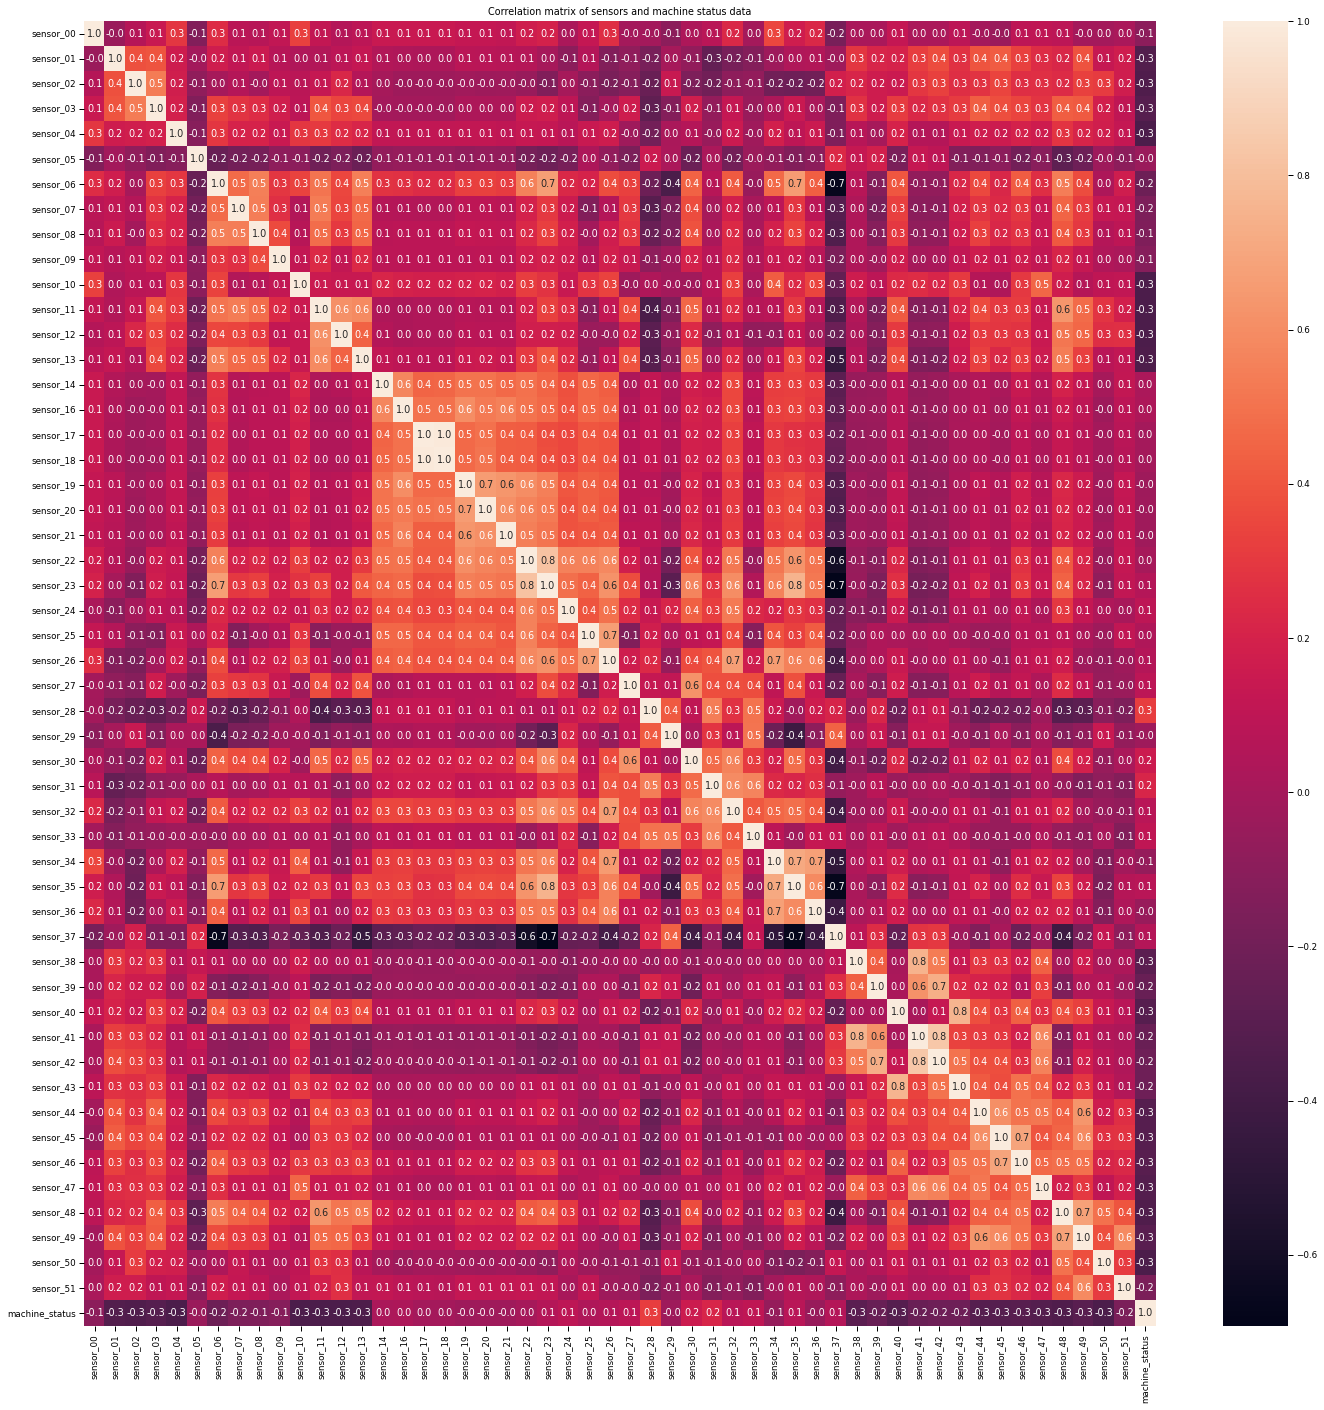

In [97]:
#Spearmanr is being used since most of our features don't follow a normal distribution
corr = dataset.corr(method='spearman')
plt.figure(figsize=(24,24))
sns.heatmap(corr, annot=True, fmt = '.1f')
plt.title("Correlation matrix of sensors and machine status data")
plt.show()

- Notice how scaling and outliers capping has affected the overall correlation.
- Instead of the strong positive correlation between sensor_14 to sensor_26 that we saw when data was raw, now the correlation is average.
- Same case with sensor_34 to sensor_36, sensor_22 to sensor_23 data.
- machine_status now has a slightly negative correlation with features 1,2,3,4,10,11,12,13, from sensor_38 to sensor_51.
- We'll store this information to be used later at the feature selection step

2. Correlation between machine_status (target variable) and other features (independant variables):

In [98]:
sensors_corr_machine=[]
machine_corr_df = dataset[dataset.columns[1:]].corr()['machine_status'][:]
for i, v in machine_corr_df.items():
  if abs(v) >= 0.3:
        print(i, ': ', round(v,2))
        sensors_corr_machine.append(i)

sensor_01 :  -0.32
sensor_02 :  -0.32
sensor_03 :  -0.31
sensor_04 :  -0.34
sensor_10 :  -0.33
sensor_11 :  -0.35
sensor_12 :  -0.36
sensor_48 :  -0.3
sensor_50 :  -0.35
machine_status :  1.0


In [99]:
sensors_corr_machine.remove('machine_status')
sensors_corr_machine

['sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_48',
 'sensor_50']

<b>Group</b> features data based on machine_status mean and plot the result to get a better sense of feature \ target relation 

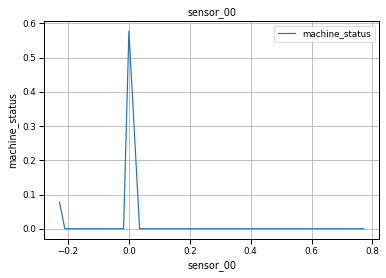

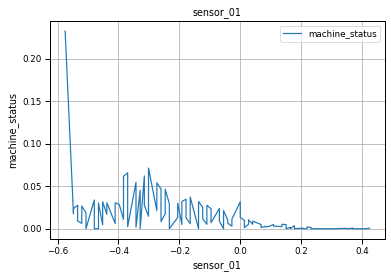

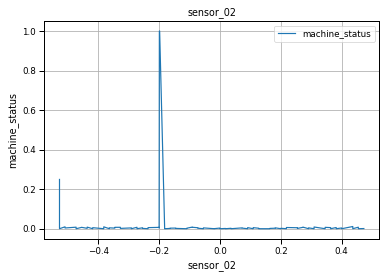

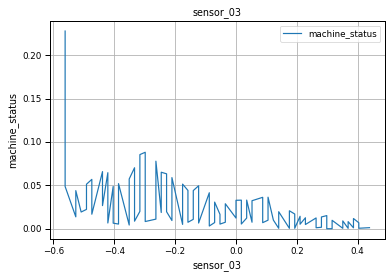

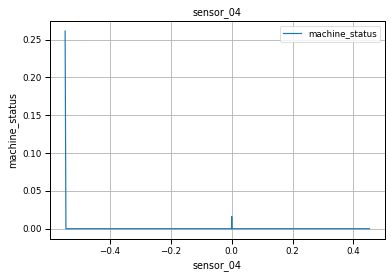

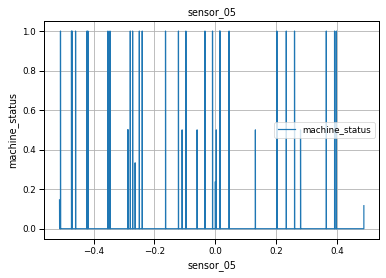

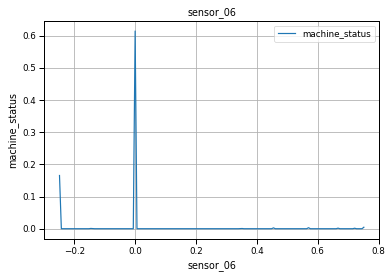

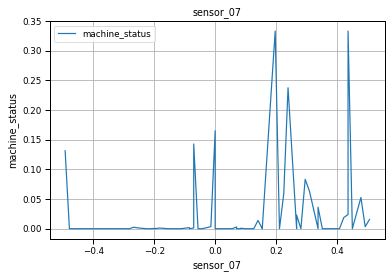

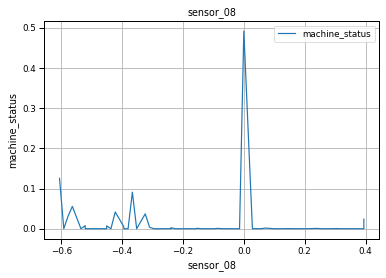

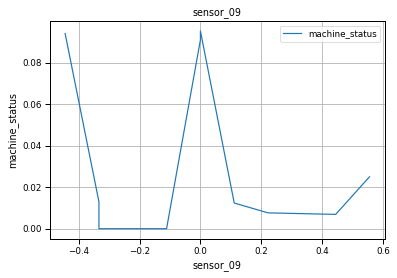

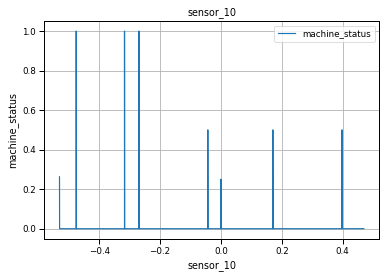

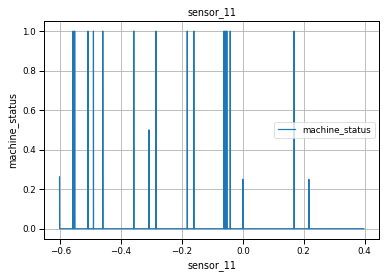

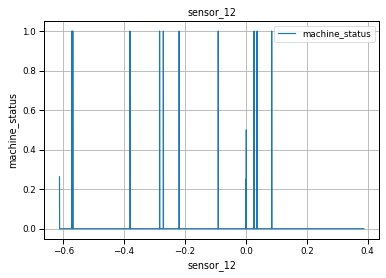

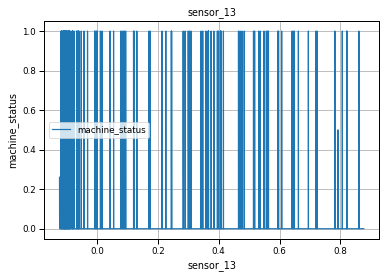

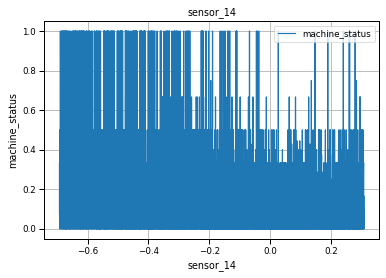

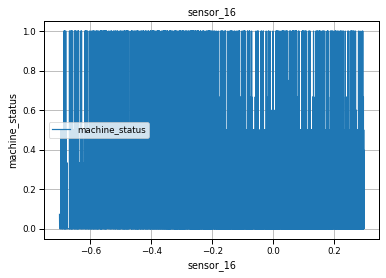

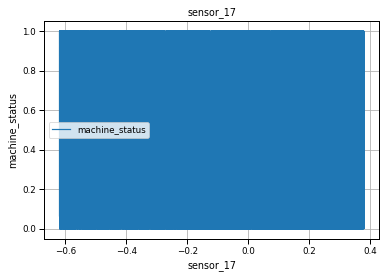

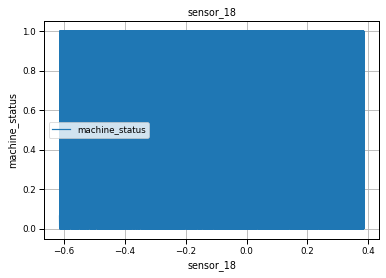

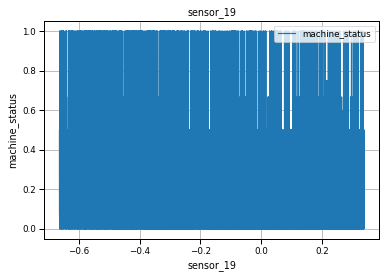

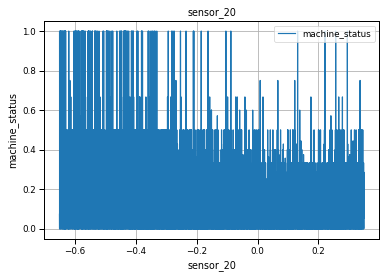

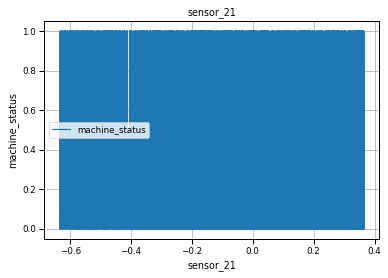

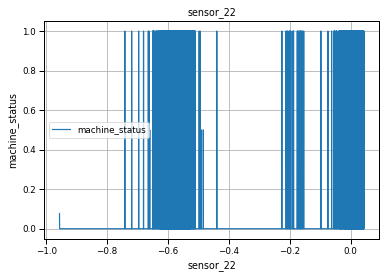

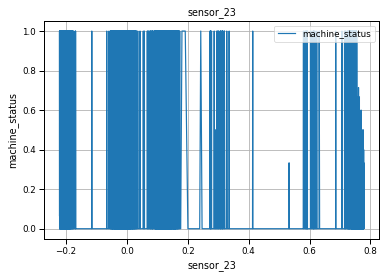

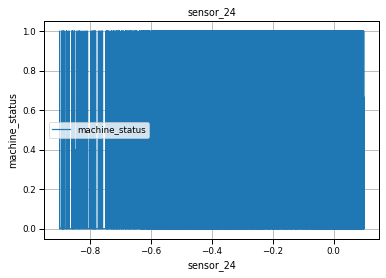

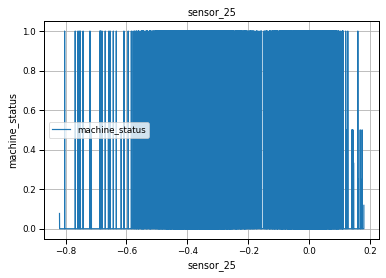

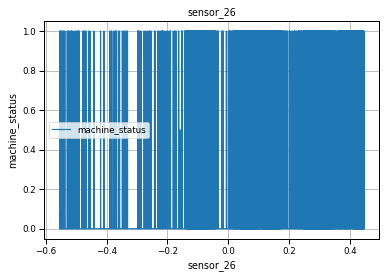

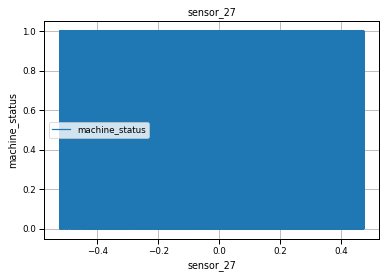

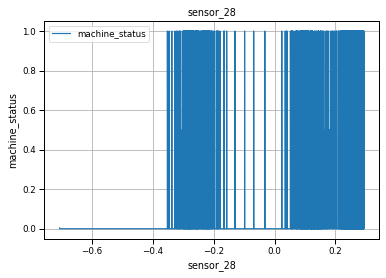

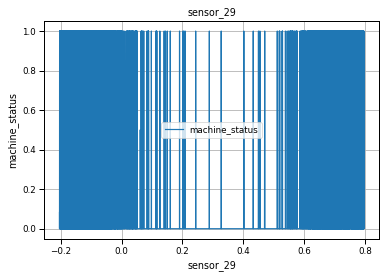

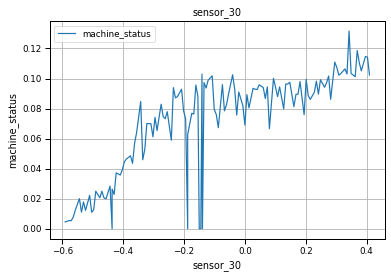

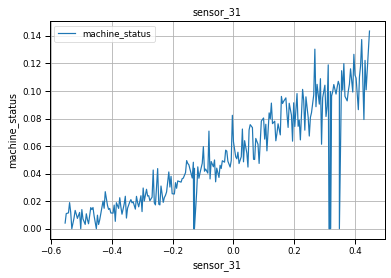

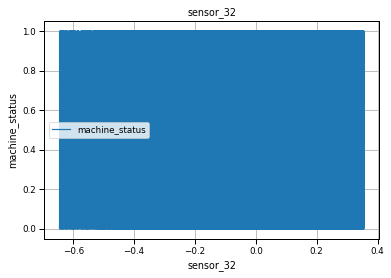

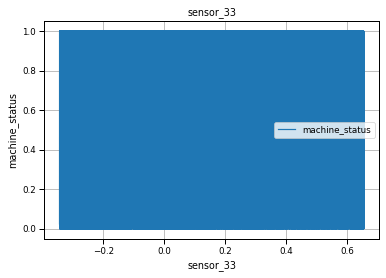

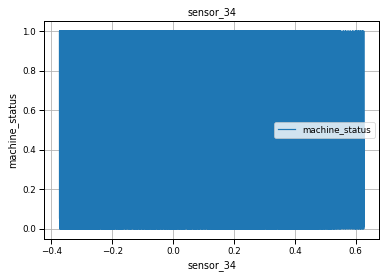

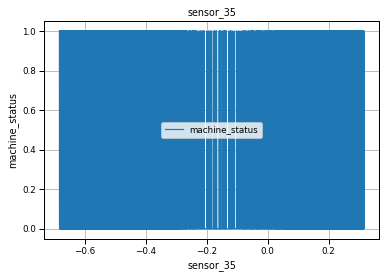

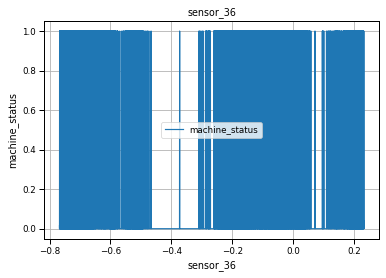

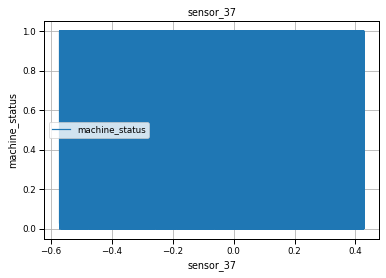

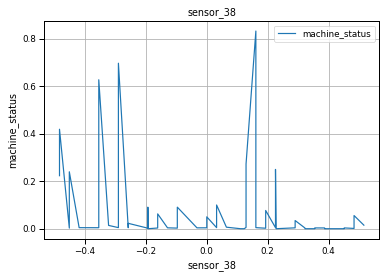

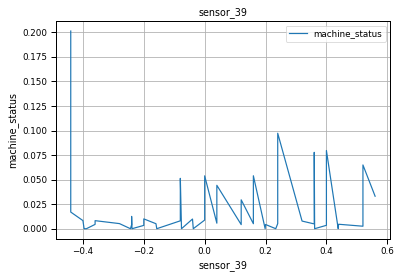

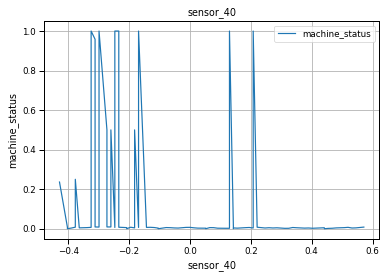

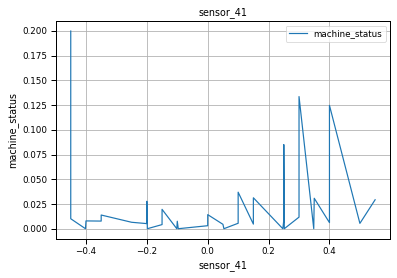

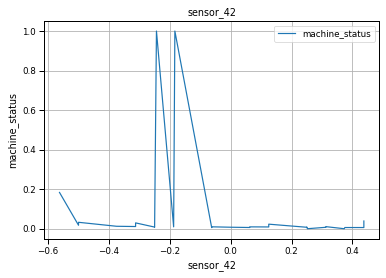

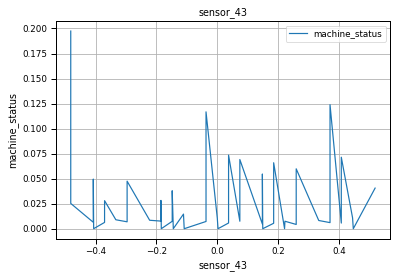

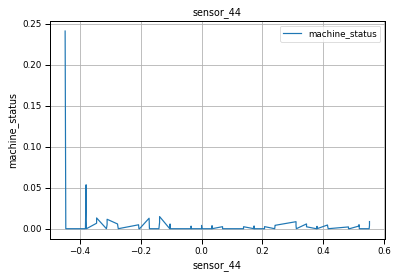

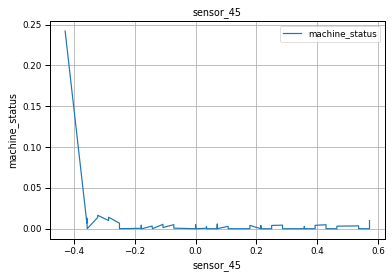

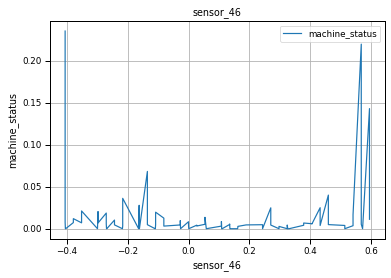

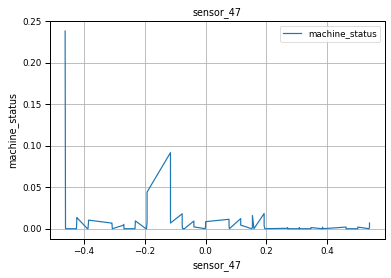

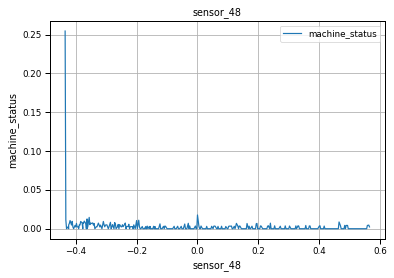

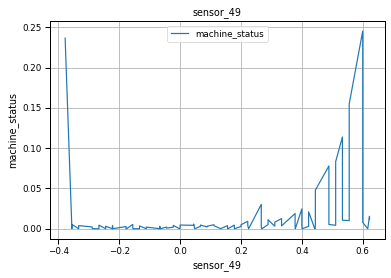

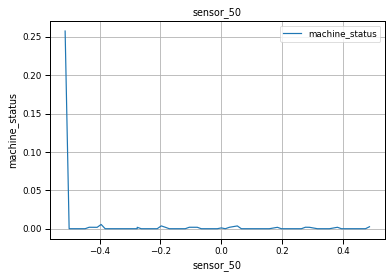

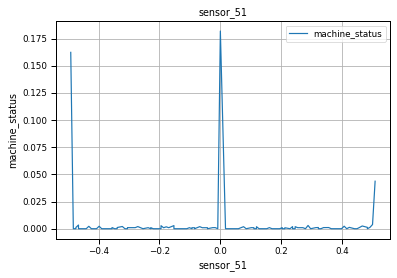

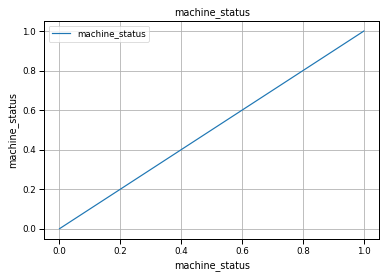

In [100]:
for feature in dataset.columns:
    dataset.groupby(feature)['machine_status'].mean().plot(legend=True)
    plt.ylabel('machine_status')
    plt.title(feature)
    plt.show()

### Feature Selection
Before applying feature selection method, we need to split the data first. The reason is that we only select features based on the information from the training set, not on the whole data set. We should hold out part of the whole data set as a test set to evaluate the performance of the feature selection and the model. Thus the information from the test set cannot be seen while we conduct feature selection and train the model.

In [101]:
#Capture the dependent feature
y = dataset['machine_status']

#Drop dependent feature from dataset
X = dataset.drop('machine_status',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
#We will apply the feature selection based on X_train and y_train

We have numerical features as input and categorical feature as an output.
With that in mind we'll test 4 selection methods and see what comes out!

### 1. ANOVA: f_classif()

In [102]:
# Univariate feature selection with F-test
# computes ANOVA f-value
# We select the most significant features
sel_f = SelectKBest(f_classif)
X_train_f = sel_f.fit_transform(X_train, y_train)
print(sel_f.get_support())

[False  True  True  True  True False False False False False  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False  True
 False  True False]


In [103]:
feat_1 = X_train.columns[(sel_f.get_support())]
print('selected features: {}'.format(len(feat_1)))
feat_1

selected features: 10


Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_44', 'sensor_48', 'sensor_50'],
      dtype='object')

### 2. Mutual Information: mutual_info_classif()

In [104]:
# Computes the mutual information
# Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. 
# It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

sel_mutual = SelectKBest(mutual_info_classif)
X_train_mutual = sel_mutual.fit_transform(X_train, y_train)
print(sel_mutual.get_support())

[ True False  True False  True False  True False False False  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False  True False]


In [105]:
feat_2 = X_train.columns[(sel_mutual.get_support())]
print('selected features: {}'.format(len(feat_2)))
feat_2

selected features: 10


Index(['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_48', 'sensor_50'],
      dtype='object')

### 3. Recursive feature elimination (RFE): 
#### - Random forest as the model

In [106]:
# Select features by recursively considering smaller and smaller sets of features.
# First, the estimator is trained on the initial set of features and the importance of each feature is obtained either 
# through a coef_ attribute or through a feature_importances_ attribute.
# Then, the least important features are pruned from the current set of features. 
# That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
sel_rfe_tree = RFE(estimator=model_tree, step=1)
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train)
print(sel_rfe_tree.get_support())

[ True  True  True False  True  True False False False False  True  True
  True  True False False False False False False False False  True False
 False  True False  True False  True False  True False False  True  True
 False  True  True  True False False False  True  True  True  True  True
 False  True False]


In [107]:
feat_3 = X_train.columns[(sel_rfe_tree.get_support())]
print('selected features: {}'.format(len(feat_3)))
feat_3

selected features: 25


Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_04', 'sensor_05',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_23',
       'sensor_26', 'sensor_28', 'sensor_30', 'sensor_32', 'sensor_35',
       'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_50'],
      dtype='object')

### 4. Select From Model: SelectFromModel
#### - Tree-based feature selection

In [108]:
# The features are considered unimportant and removed if the corresponding coef_ or feature_importances_ values are 
# below the provided threshold parameter.
# Compared to univariate feature selection, model-based feature selection consider all feature at once,
# thus can capture interactions. 
# The model used for the feature selection doesn’t need to be the same model for the training later.

model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X_train, y_train)
print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean')  
      # since we already fit the data, we specify prefit option here
      # Features whose importance is greater or equal to the threshold are kept while the others are discarded.
X_train_sfm_tree = sel_model_tree.transform(X_train)
print(sel_model_tree.get_support())

[0.01558642 0.03559385 0.02795093 0.00479394 0.04973119 0.0109425
 0.00343003 0.00329359 0.00243408 0.00224016 0.07170345 0.06358116
 0.08455074 0.09531087 0.00126026 0.00086702 0.0012091  0.00073576
 0.00115312 0.00084748 0.00119654 0.0033115  0.00873003 0.00402018
 0.00392949 0.01061615 0.01626969 0.0452639  0.00424561 0.01990727
 0.010555   0.00802729 0.00235665 0.00411518 0.00662586 0.02141204
 0.00310721 0.04205941 0.04971828 0.04846637 0.01330397 0.0145154
 0.00586478 0.02282183 0.04601983 0.01489835 0.00851878 0.02296551
 0.00899009 0.04638778 0.00456437]
[False  True  True False  True False False False False False  True  True
  True  True False False False False False False False False False False
 False False False  True False  True False False False False False  True
 False  True  True  True False False False  True  True False False  True
 False  True False]


In [109]:
# make a list of the selected features
feat_4 = X_train.columns[(sel_model_tree.get_support())]
print('selected features: {}'.format(len(feat_4)))
feat_4

selected features: 17


Index(['sensor_01', 'sensor_02', 'sensor_04', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_28', 'sensor_30', 'sensor_36',
       'sensor_38', 'sensor_39', 'sensor_40', 'sensor_44', 'sensor_45',
       'sensor_48', 'sensor_50'],
      dtype='object')

# Selecting Features:

Finally, we select features based on intersection between:
- sensors_with_trends: calculated above
- sensors_corr_machine: calculated above
- Anova: F-test
- Mutual_info_classif test
- Recursive feature elimination with random forest as the model
- SelectFromModel: tree based feature selection
- If feature appears in **Two** or more selected lists => select the feature.

In [110]:
combined_list = sensors_with_trends + sensors_corr_machine + feat_1.tolist() + feat_2.tolist() +feat_3.tolist() + feat_4.tolist()

In [111]:
from collections import Counter
counter = Counter(combined_list)
print(counter)
 
selected_features = list([item for item in counter if counter[item]>1])
print(selected_features)

Counter({'sensor_04': 6, 'sensor_10': 6, 'sensor_11': 6, 'sensor_12': 6, 'sensor_02': 5, 'sensor_48': 5, 'sensor_50': 5, 'sensor_13': 4, 'sensor_01': 4, 'sensor_00': 3, 'sensor_44': 3, 'sensor_05': 2, 'sensor_06': 2, 'sensor_03': 2, 'sensor_28': 2, 'sensor_30': 2, 'sensor_36': 2, 'sensor_38': 2, 'sensor_39': 2, 'sensor_40': 2, 'sensor_45': 2, 'sensor_07': 1, 'sensor_23': 1, 'sensor_26': 1, 'sensor_32': 1, 'sensor_35': 1, 'sensor_46': 1, 'sensor_47': 1})
['sensor_00', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_48', 'sensor_50', 'sensor_44', 'sensor_28', 'sensor_30', 'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_45']


In [112]:
X_train = X_train[selected_features]
X_train.columns

Index(['sensor_00', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_48', 'sensor_50', 'sensor_44', 'sensor_28',
       'sensor_30', 'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_45'],
      dtype='object')

In [113]:
X_test = X_test[selected_features]
X_test.shape

(66096, 21)

### Model Building:

We'll try multiple models and select the most accurate one. 
Models include: Logistic Regression - Decision Tree - Random Forest - Xgboost

- Hyperparameter Tuning: it's required to get the most out of our ML model. Random Search is used here.


### I. Logistic Regression for Binary Classification

In [114]:
from scipy.stats import loguniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict() 
space['solver'] = ['saga']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)
space['tol'] = [0.0001,0.001,0.01,0.1]
space['max_iter'] = [20,50,100,200] 
# define search
search = RandomizedSearchCV(model, space, n_iter=60, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

In [115]:
# execute search
result = search.fit(X_train, y_train)

In [116]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9938055461471034
Best Hyperparameters: {'C': 83.56561666138202, 'max_iter': 20, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}


In [117]:
#Apply the selected best parameters to Logistic Regression and fit the model
LR = LogisticRegression(**result.best_params_)
LR_model = LR.fit(X_train, y_train)
LR_y_pred = LR_model.predict(X_test)

### Classification Accuracy for Logistic Regression Model

In [118]:
LR_Accuracy = accuracy_score(y_test, LR_y_pred)
LR_Accuracy

0.9936304768821108

### Confusion Matrix for Logistic Regression Model

[Text(32.7, 0.5, 'Actual Values'), Text(0.5, 14.7, 'Predicted Values')]

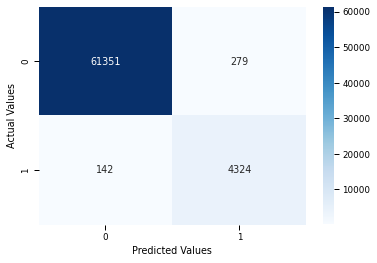

In [119]:
LR_Cm = confusion_matrix(y_test, LR_y_pred)
ax = sns.heatmap(LR_Cm, annot=True,fmt="d", cmap="Blues")
ax.set(xlabel = "Predicted Values", ylabel="Actual Values")

Correct Predictions = 61352 + 4324 = 65676

Inocrrect Predictions = 142 + 278 = 420

### Classification Report for Logistic Regression Model

In [120]:
LR_Cr = classification_report(y_test, LR_y_pred)
print(LR_Cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61630
           1       0.94      0.97      0.95      4466

    accuracy                           0.99     66096
   macro avg       0.97      0.98      0.98     66096
weighted avg       0.99      0.99      0.99     66096



### II. Decision Tree

In [121]:
from sklearn import tree
DT = tree.DecisionTreeClassifier()
DT_model = DT.fit(X_train, y_train)
DT_y_pred = DT_model.predict(X_test)

### Classification Accuracy for Decision Tree Model

In [122]:
DT_accuracy = accuracy_score(y_test, DT_y_pred)
DT_accuracy

0.9977003146937787

###Confusion Matrix for Decision Tree Model

[Text(32.7, 0.5, 'Actual Values'), Text(0.5, 14.7, 'Predicted Values')]

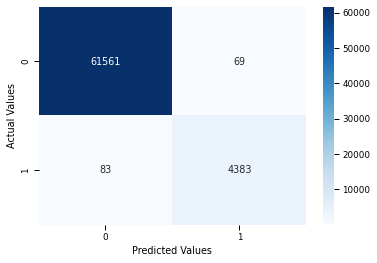

In [123]:
DT_Cm = confusion_matrix(y_test, DT_y_pred)
ax = sns.heatmap(DT_Cm, annot=True,fmt="d", cmap="Blues")
ax.set(xlabel = "Predicted Values", ylabel="Actual Values")

Correct Predictions = 61565 + 4386 = 65951

Inocrrect Predictions = 80 + 65 = 145

### Classification Report for Decision Tree Model

In [124]:
DT_Cr = classification_report(y_test, DT_y_pred)
print(DT_Cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61630
           1       0.98      0.98      0.98      4466

    accuracy                           1.00     66096
   macro avg       0.99      0.99      0.99     66096
weighted avg       1.00      1.00      1.00     66096



### III. Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
import math 

# define model
model = RandomForestClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model_params
model_params = {
    # set to default
    'n_estimators': [100],
    # this is a classification problem => max_features better to be = sqrt(total_input_features)
    'max_features': ['sqrt'],
    # set to default
    'min_samples_split': [2]
}
# define search
search = RandomizedSearchCV(model,model_params, n_iter=60, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1,error_score='raise')

In [126]:
# execute search
result = search.fit(X_train, y_train)

In [127]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9985713436011603
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt'}


In [128]:
#Apply the selected best parameters to Random Forest and fit the model
RF = RandomForestClassifier(**result.best_params_)
RF_model = RF.fit(X_train, y_train)
RF_y_pred = RF_model.predict(X_test)

### Classification Accuracy for Random Forest Model

In [129]:
RF_accuracy = accuracy_score(y_test, RF_y_pred)
RF_accuracy

0.9985324376664246

### Confusion Matrix for Random Forest Model

[Text(32.7, 0.5, 'Actual Values'), Text(0.5, 14.7, 'Predicted Values')]

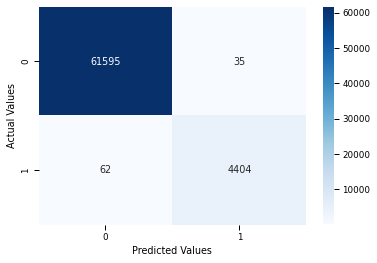

In [130]:
RF_Cm = confusion_matrix(y_test, RF_y_pred)
ax = sns.heatmap(RF_Cm, annot=True,fmt="d", cmap="Blues")
ax.set(xlabel = "Predicted Values", ylabel="Actual Values")

Correct Predictions = 61596 + 4407 = 66003

Inocrrect Predictions = 59 + 34 = 93

### Classification Report for Random Forest Model

In [131]:
RF_Cr = classification_report(y_test, RF_y_pred)
print(RF_Cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61630
           1       0.99      0.99      0.99      4466

    accuracy                           1.00     66096
   macro avg       1.00      0.99      0.99     66096
weighted avg       1.00      1.00      1.00     66096



#### IV. Xgboost

In [132]:
from xgboost import XGBClassifier

model = XGBClassifier(objective = 'binary:logistic')

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model_params = {'n_estimators': [100],
              'learning_rate': [0.001],
              'max_depth': [3, 7, 9]
             }

search = RandomizedSearchCV(model, model_params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1,error_score='raise')

In [133]:
# execute search
result = search.fit(X_train, y_train)

In [134]:
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9991109263383758
Best Hyperparameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.001}


In [ ]:
#Apply the selected best parameters to XGBoost and fit the model
XGB = XGBClassifier(**result.best_params_)
XGB_model = XGB.fit(X_train, y_train)
XGB_y_pred = XGB_model.predict(X_test)

### Classification Accuracy for XGBoost Model

In [136]:
XGB_accuracy = accuracy_score(y_test, XGB_y_pred)
XGB_accuracy

0.9965958605664488

### Confusion Matrix for XGBoost Model

[Text(32.7, 0.5, 'Actual Values'), Text(0.5, 14.7, 'Predicted Values')]

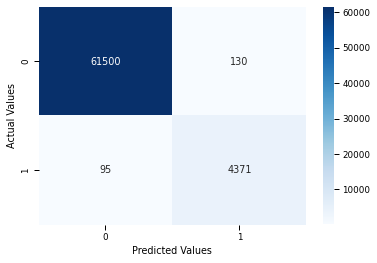

In [137]:
XGB_Cm = confusion_matrix(y_test, XGB_y_pred)
ax = sns.heatmap(XGB_Cm, annot=True,fmt="d", cmap="Blues")
ax.set(xlabel = "Predicted Values", ylabel="Actual Values")

Correct Predictions = 61500 + 4371 = 65871

Incorrect Predictions = 95 + 130 = 225

### Classification Report for XGBoost Model

In [138]:
XGB_Cr = classification_report(y_test, XGB_y_pred)
print(XGB_Cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61630
           1       0.97      0.98      0.97      4466

    accuracy                           1.00     66096
   macro avg       0.98      0.99      0.99     66096
weighted avg       1.00      1.00      1.00     66096



Based on our analysis Random Forest has given better results compared to Xgboost, Decision Tree and Logistic Regression.